In [204]:
import sqlite3
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 7)

DB_PATH = Path.cwd().parent / "CAR_DATA_OUTPUT" / "CAR_DATA.db"
conn = sqlite3.connect(DB_PATH)


In [157]:
listings = pd.read_sql_query("SELECT * FROM listings", conn)
price_history = pd.read_sql_query("SELECT * FROM price_history", conn)
listing_history = pd.read_sql_query("SELECT * FROM listing_history", conn)
nhtsa_enrichment = pd.read_sql_query("SELECT * FROM nhtsa_enrichment", conn)

listings['price'] = pd.to_numeric(listings['price'], errors='coerce')
listings['mileage'] = pd.to_numeric(listings['mileage'], errors='coerce')
listings['year'] = pd.to_numeric(listings['year'], errors='coerce')

if price_history['price'].dtype == 'object':
    price_history['price'] = price_history['price'].astype(str).str.replace('$', '', regex=False).str.replace(',', '', regex=False).str.strip()
price_history['price'] = pd.to_numeric(price_history['price'], errors='coerce')
price_history['mileage'] = pd.to_numeric(price_history['mileage'], errors='coerce')

if listing_history['price'].dtype == 'object':
    listing_history['price'] = listing_history['price'].astype(str).str.replace('$', '', regex=False).str.replace(',', '', regex=False).str.strip()
listing_history['price'] = pd.to_numeric(listing_history['price'], errors='coerce')
listing_history['mileage'] = pd.to_numeric(listing_history['mileage'], errors='coerce')


In [158]:
# # Exploratory Data Analysis - Car Market Dataset


In [159]:
# ## 1. Dataset Overview


In [160]:
print("="*80)
print("DATASET OVERVIEW")
print("="*80)
print(f"\nTotal unique VINs: {listings['vin'].nunique():,}")
print(f"Total listing records: {len(listings):,}")
print(f"Date range: {listings['loaddate'].min()} to {listings['loaddate'].max()}")
print(f"\nPrice Statistics:")
print(f"  Min: ${listings['price'].min():,.0f}")
print(f"  Max: ${listings['price'].max():,.0f}")
print(f"  Mean: ${listings['price'].mean():,.0f}")
print(f"  Median: ${listings['price'].median():,.0f}")
print(f"\nMileage Statistics:")
print(f"  Min: {listings['mileage'].min():,.0f} miles")
print(f"  Max: {listings['mileage'].max():,.0f} miles")
print(f"  Mean: {listings['mileage'].mean():,.0f} miles")
print(f"  Median: {listings['mileage'].median():,.0f} miles")


DATASET OVERVIEW

Total unique VINs: 651,780
Total listing records: 651,857
Date range: 2026-02-12 to 2026-02-14

Price Statistics:
  Min: $90
  Max: $4,590,000
  Mean: $31,099
  Median: $24,995

Mileage Statistics:
  Min: 1 miles
  Max: 123,456,789 miles
  Mean: 55,197 miles
  Median: 45,095 miles


In [161]:
# ## 2. Data Quality Assessment


In [162]:
print("\n" + "="*80)
print("DATA QUALITY - MISSING VALUES")
print("="*80)
missing_stats = pd.DataFrame({
    'Missing Count': listings.isnull().sum(),
    'Missing %': (listings.isnull().sum() / len(listings) * 100).round(2)
})
missing_stats = missing_stats[missing_stats['Missing Count'] > 0].sort_values('Missing Count', ascending=False)
print(missing_stats)

print("\n" + "="*80)
print("NUMERIC COLUMNS - DESCRIPTIVE STATISTICS")
print("="*80)
print(listings[["year", "price", "mileage"]].describe().round(2))



DATA QUALITY - MISSING VALUES
            Missing Count  Missing %
bids               650907      99.85
currentBid         649160      99.59
mileage              8471       1.30
price                7547       1.16
details              3165       0.49
sourceName            608       0.09
distance              210       0.03

NUMERIC COLUMNS - DESCRIPTIVE STATISTICS
            year       price       mileage
count  651857.00   644310.00  6.433860e+05
mean     2019.77    31098.77  5.519707e+04
std        10.94    29682.92  2.695986e+05
min         0.00       90.00  1.000000e+00
25%      2018.00    17995.00  2.108825e+04
50%      2022.00    24995.00  4.509500e+04
75%      2024.00    35995.00  7.964175e+04
max      2027.00  4590000.00  1.234568e+08


In [163]:
# ## 3. Make & Model Analysis


In [164]:
listings['make'] = listings['title'].str.extract(r'^(\d+)\s+([^\s]+)', expand=True)[1]
listings['model'] = listings['title'].str.extract(r'^(\d+)\s+[^\s]+\s+(.+)$', expand=True)[1]

print("\n" + "="*80)
print("TOP 15 VEHICLE MAKES")
print("="*80)
make_dist = listings['make'].value_counts().head(15)
print(make_dist)

print("\n" + "="*80)
print("PRICE STATISTICS BY TOP 10 MAKES")
print("="*80)
top_makes = listings['make'].value_counts().head(10).index
price_by_make = listings[listings['make'].isin(top_makes)].groupby('make')['price'].agg(
    Count='count',
    Mean='mean',
    Median='median',
    Std_Dev='std',
    Min='min',
    Max='max'
).round(2)
price_by_make = price_by_make.sort_values(by='Mean', ascending=False)
print(price_by_make)

print("\n" + "="*80)
print("MILEAGE STATISTICS BY TOP 10 MAKES")
print("="*80)
mileage_by_make = listings[listings['make'].isin(top_makes)].groupby('make')['mileage'].agg(
    Count='count',
    Mean='mean',
    Median='median',
    Std_Dev='std',
    Min='min',
    Max='max'
).round(2)
mileage_by_make = mileage_by_make.sort_values(by='Mean', ascending=False)
print(mileage_by_make)



TOP 15 VEHICLE MAKES
make
Nissan           35397
Hyundai          35229
Honda            35222
Subaru           35179
Volkswagen       34979
Toyota           34836
Ford             34564
Jeep             34281
Chevrolet        33962
BMW              33567
Mercedes-Benz    32954
GMC              32925
Kia              32834
Mazda            29027
Dodge            27227
Name: count, dtype: int64

PRICE STATISTICS BY TOP 10 MAKES
            Count      Mean   Median   Std_Dev     Min        Max
make                                                             
BMW         33497  37558.09  34250.0  24468.82  1250.0  1000803.0
Ford        34180  34048.99  28610.5  30681.53    90.0  2500000.0
Chevrolet   33501  33137.82  24998.0  26904.85   160.0  1500000.0
Toyota      34756  27697.69  25590.0  12394.97   150.0   400000.0
Jeep        34233  26434.09  24990.0  12801.99  1000.0   299995.0
Honda       35144  24374.59  23988.0  20137.34   300.0  3325822.0
Subaru      34859  22780.05  23490.0   8

In [165]:
# ## 4. Year Analysis


In [166]:
print("\n" + "="*80)
print("VEHICLE YEAR DISTRIBUTION")
print("="*80)
year_counts = listings['year'].value_counts().sort_index(ascending=False).head(20)
print(year_counts)

print("\n" + "="*80)
print("PRICE & MILEAGE BY VEHICLE YEAR (Top 20 years)")
print("="*80)
top_years = listings['year'].value_counts().head(20).index
year_stats = listings[listings['year'].isin(top_years)].groupby('year').agg({
    'price': ['count', 'mean', 'median', 'std'],
    'mileage': ['mean', 'median', 'std']
}).round(2).sort_index(ascending=False)
year_stats.columns = ['Count', 'Price Mean', 'Price Median', 'Price Std', 'Mileage Mean', 'Mileage Median', 'Mileage Std']
print(year_stats)



VEHICLE YEAR DISTRIBUTION
year
2027      108
2026    25856
2025    86328
2024    84476
2023    98435
2022    62363
2021    46747
2020    40687
2019    40515
2018    33866
2017    27831
2016    22043
2015    18035
2014    12552
2013     9374
2012     6014
2011     4650
2010     3482
2009     2180
2008     2669
Name: count, dtype: int64

PRICE & MILEAGE BY VEHICLE YEAR (Top 20 years)
      Count  Price Mean  Price Median  Price Std  Mileage Mean  \
year                                                             
2026  25612    55383.74       47289.0   36225.47       1562.42   
2025  85671    42209.86       34855.0   31675.00      12987.75   
2024  83840    38045.43       30499.0   29923.48      29281.30   
2023  97590    34291.80       28998.0   21374.96      36362.22   
2022  61919    32224.20       27300.0   22515.58      47660.33   
2021  46366    28761.07       24690.0   18930.11      61536.66   
2020  40337    24722.75       21895.0   15496.65      69832.82   
2019  40103    22310

In [167]:
# ## 5. Price Analysis


In [168]:
print("\n" + "="*80)
print("TOP 10 MOST EXPENSIVE VEHICLES")
print("="*80)
top_price = listings.nlargest(10, 'price')[['year', 'make', 'model', 'title', 'price', 'mileage', 'location']].reset_index(drop=True)
top_price.index = top_price.index + 1
print(top_price.to_string())

print("\n" + "="*80)
print("TOP 10 LEAST EXPENSIVE VEHICLES")
print("="*80)
bottom_price = listings.nsmallest(10, 'price')[['year', 'make', 'model', 'title', 'price', 'mileage', 'location']].reset_index(drop=True)
bottom_price.index = bottom_price.index + 1
print(bottom_price.to_string())



TOP 10 MOST EXPENSIVE VEHICLES
    year           make                                       model                                                  title      price  mileage           location
1   2015        Porsche               918 Spyder w/Weissach Package             2015 Porsche 918 Spyder w/Weissach Package  4590000.0     66.0  Lawrenceville, NJ
2   2015        Porsche          918 Spyder Base w/Weissach Package        2015 Porsche 918 Spyder Base w/Weissach Package  3499999.0   2998.0      Las Vegas, NV
3   2015        Porsche          918 Spyder Base w/Weissach Package        2015 Porsche 918 Spyder Base w/Weissach Package  3475990.0   5227.0     Carrollton, TX
4   2025          Honda                                Accord Sport                                2025 Honda Accord Sport  3325822.0      2.0       Brooklyn, NY
5   1965           Ford                                        GT40                                         1965 Ford GT40  2500000.0     10.0  Hermosa Beach,

In [169]:
# ## 6. Mileage Analysis


In [170]:
print("\n" + "="*80)
print("TOP 10 HIGHEST MILEAGE VEHICLES")
print("="*80)
high_mileage = listings.nlargest(10, 'mileage')[['year', 'make', 'model', 'title', 'price', 'mileage', 'location']].reset_index(drop=True)
high_mileage.index = high_mileage.index + 1
print(high_mileage.to_string())

print("\n" + "="*80)
print("TOP 10 LOWEST MILEAGE VEHICLES")
print("="*80)
low_mileage = listings.nsmallest(10, 'mileage')[['year', 'make', 'model', 'title', 'price', 'mileage', 'location']].reset_index(drop=True)
low_mileage.index = low_mileage.index + 1
print(low_mileage.to_string())



TOP 10 HIGHEST MILEAGE VEHICLES
    year       make                                     model                                               title    price      mileage                location
1   1971      Dodge                                      Dart                                     1971 Dodge Dart  27500.0  123456789.0              Aromas, CA
2   1964  Chevrolet                                   Bel Air                              1964 Chevrolet Bel Air  16500.0   99999999.0             McAllen, TX
3   1955      Dodge                                        D8                                       1955 Dodge D8      NaN   99999999.0          Fort Myers, FL
4   1968      Dodge                                   Charger                                  1968 Dodge Charger  24500.0   99999999.0  North Myrtle Beach, SC
5   1968       Ford                                   Mustang                                   1968 Ford Mustang      NaN   11111111.0            Chandler, AZ
6   197

In [171]:
# ## 7. Location Analysis


In [172]:
print("\n" + "="*80)
print("TOP 20 LOCATIONS BY LISTING COUNT")
print("="*80)
location_counts = listings['location'].value_counts().head(20)
print(location_counts)

print("\n" + "="*80)
print("PRICE STATISTICS BY TOP 15 LOCATIONS")
print("="*80)
top_locations = listings['location'].value_counts().head(15).index
price_by_location = listings[listings['location'].isin(top_locations)].groupby('location')['price'].agg(
    Count='count',
    Mean='mean',
    Median='median',
    Std_Dev='std'
).round(2)
price_by_location = price_by_location.sort_values(by='Mean', ascending=False)
print(price_by_location)

print("\n" + "="*80)
print("MILEAGE STATISTICS BY TOP 15 LOCATIONS")
print("="*80)
mileage_by_location = listings[listings['location'].isin(top_locations)].groupby('location')['mileage'].agg(
    Count='count',
    Mean='mean',
    Median='median',
    Std_Dev='std'
).round(2)
mileage_by_location = mileage_by_location.sort_values(by='Mean', ascending=False)
print(mileage_by_location)



TOP 20 LOCATIONS BY LISTING COUNT
location
Houston, TX             10964
Orlando, FL              8263
Miami, FL                7737
Tampa, FL                7216
Jacksonville, FL         6896
San Antonio, TX          5592
Fort Worth, TX           3805
Las Vegas, NV            3682
Dallas, TX               3399
Austin, TX               3244
Oklahoma City, OK        3023
Fort Myers, FL           2966
Haines City, FL          2899
Raleigh, NC              2764
Phoenix, AZ              2717
Plano, TX                2661
Sacramento, CA           2650
Colonial Heights, VA     2626
Columbus, OH             2614
Indianapolis, IN         2411
Name: count, dtype: int64

PRICE STATISTICS BY TOP 15 LOCATIONS
                   Count      Mean   Median   Std_Dev
location                                             
Dallas, TX          3360  35263.22  27888.0  35550.50
Las Vegas, NV       3641  34538.41  23500.0  70067.24
Miami, FL           7652  33769.80  23990.0  41706.27
Houston, TX        108

In [173]:
# ## 8. Price Distribution Analysis


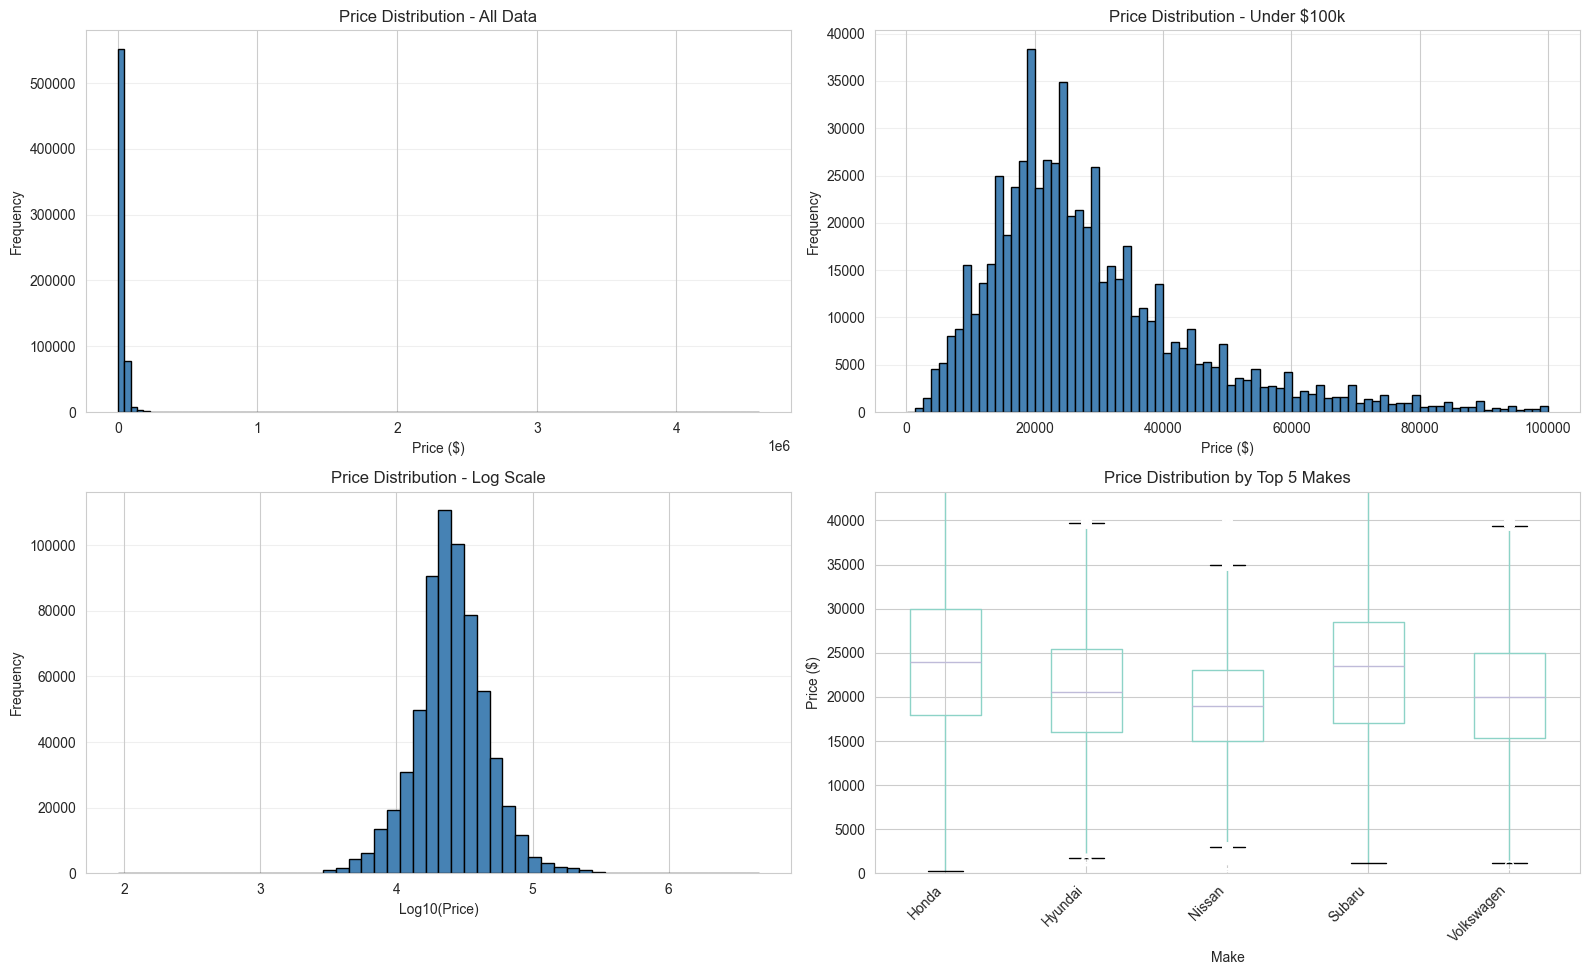

In [174]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

listings['price'].hist(bins=100, ax=axes[0, 0], edgecolor='black', color='steelblue')
axes[0, 0].set_xlabel('Price ($)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Price Distribution - All Data')
axes[0, 0].grid(axis='y', alpha=0.3)

listings[listings['price'] < 100000]['price'].hist(bins=80, ax=axes[0, 1], edgecolor='black', color='steelblue')
axes[0, 1].set_xlabel('Price ($)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Price Distribution - Under $100k')
axes[0, 1].grid(axis='y', alpha=0.3)

listings[listings['price'] > 0]['price'].apply(np.log10).hist(bins=50, ax=axes[1, 0], edgecolor='black', color='steelblue')
axes[1, 0].set_xlabel('Log10(Price)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Price Distribution - Log Scale')
axes[1, 0].grid(axis='y', alpha=0.3)

top_5_makes = listings['make'].value_counts().head(5).index
top_5_data = listings[listings['make'].isin(top_5_makes)]
top_5_data.boxplot(column='price', by='make', ax=axes[1, 1])
axes[1, 1].set_xlabel('Make')
axes[1, 1].set_ylabel('Price ($)')
axes[1, 1].set_title('Price Distribution by Top 5 Makes')
axes[1, 1].get_figure().suptitle('')

price_q1 = top_5_data['price'].quantile(0.25)
price_q3 = top_5_data['price'].quantile(0.75)
price_iqr = price_q3 - price_q1
price_lower = max(0, price_q1 - 1.5 * price_iqr)
price_upper = price_q3 + 1.5 * price_iqr
axes[1, 1].set_ylim(price_lower, price_upper)

plt.setp(axes[1, 1].xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()


In [175]:
# ## 9. Mileage Distribution Analysis


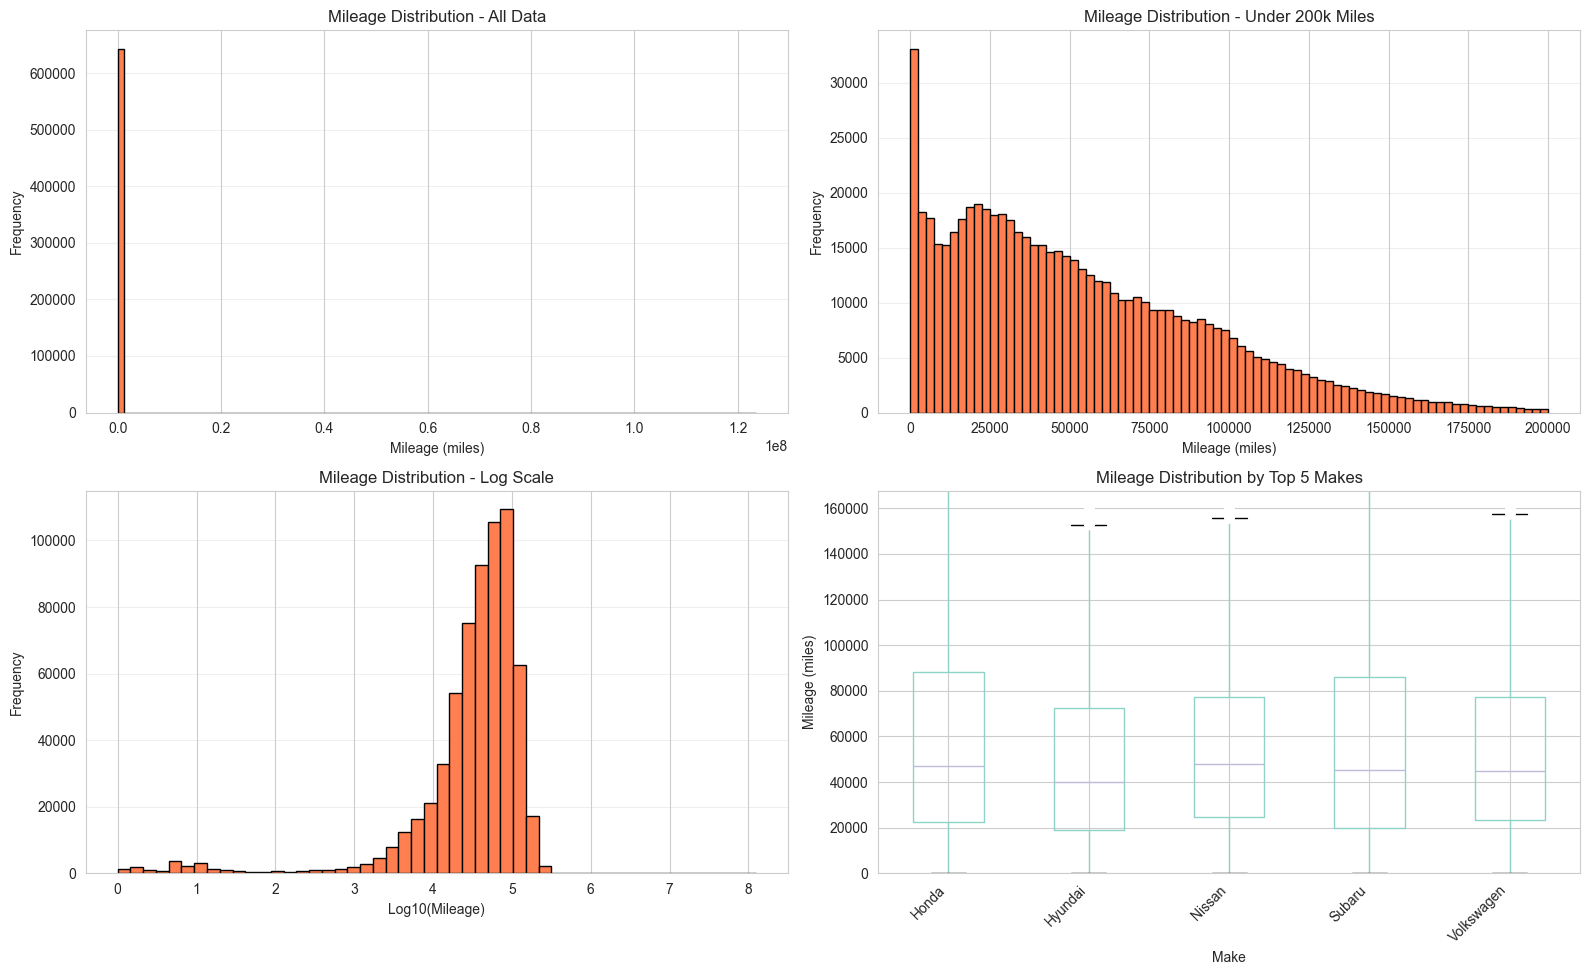

In [176]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

listings['mileage'].hist(bins=100, ax=axes[0, 0], edgecolor='black', color='coral')
axes[0, 0].set_xlabel('Mileage (miles)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Mileage Distribution - All Data')
axes[0, 0].grid(axis='y', alpha=0.3)

listings[listings['mileage'] < 200000]['mileage'].hist(bins=80, ax=axes[0, 1], edgecolor='black', color='coral')
axes[0, 1].set_xlabel('Mileage (miles)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Mileage Distribution - Under 200k Miles')
axes[0, 1].grid(axis='y', alpha=0.3)

listings[listings['mileage'] > 0]['mileage'].apply(np.log10).hist(bins=50, ax=axes[1, 0], edgecolor='black', color='coral')
axes[1, 0].set_xlabel('Log10(Mileage)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Mileage Distribution - Log Scale')
axes[1, 0].grid(axis='y', alpha=0.3)

top_5_data.boxplot(column='mileage', by='make', ax=axes[1, 1])
axes[1, 1].set_xlabel('Make')
axes[1, 1].set_ylabel('Mileage (miles)')
axes[1, 1].set_title('Mileage Distribution by Top 5 Makes')
axes[1, 1].get_figure().suptitle('')

mileage_q1 = top_5_data['mileage'].quantile(0.25)
mileage_q3 = top_5_data['mileage'].quantile(0.75)
mileage_iqr = mileage_q3 - mileage_q1
mileage_lower = max(0, mileage_q1 - 1.5 * mileage_iqr)
mileage_upper = mileage_q3 + 1.5 * mileage_iqr
axes[1, 1].set_ylim(mileage_lower, mileage_upper)

plt.setp(axes[1, 1].xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()


In [177]:
# ## 10. Price vs Mileage Relationship


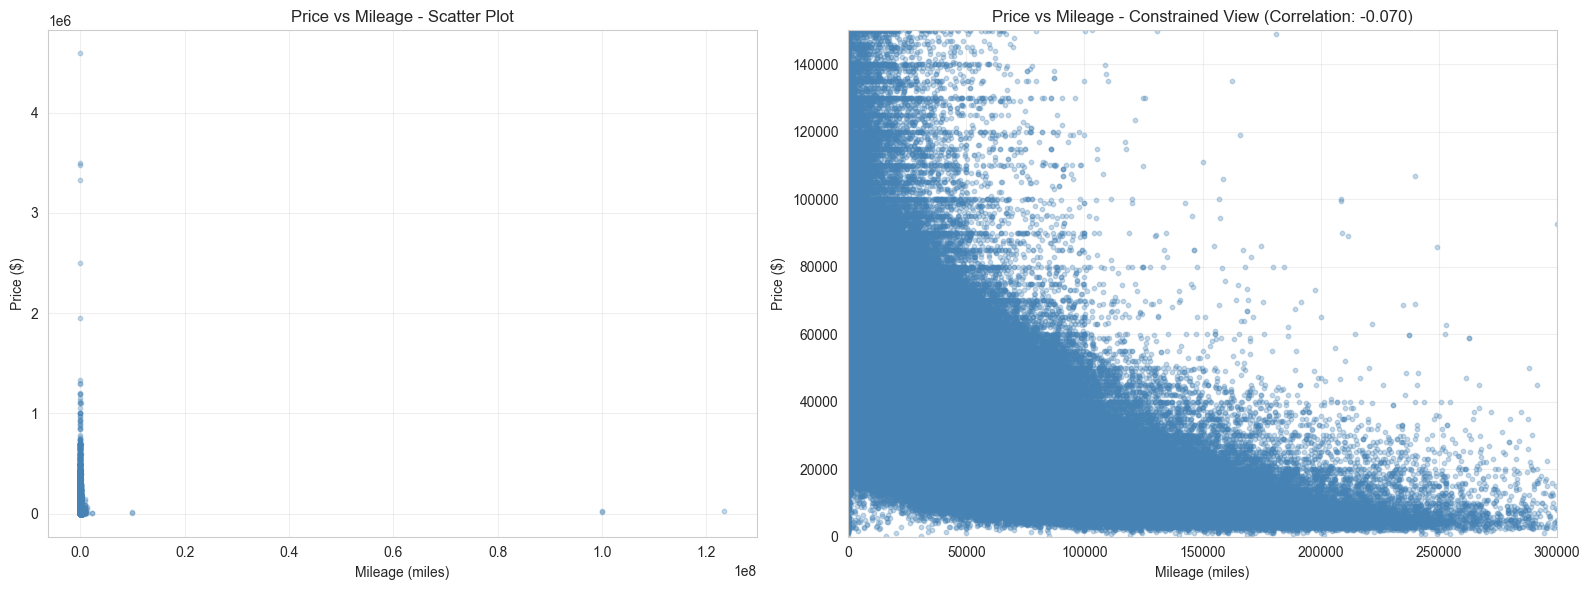


Price-Mileage Correlation: -0.0695


In [178]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].scatter(listings['mileage'], listings['price'], alpha=0.3, s=10, color='steelblue')
axes[0].set_xlabel('Mileage (miles)')
axes[0].set_ylabel('Price ($)')
axes[0].set_title('Price vs Mileage - Scatter Plot')
axes[0].grid(True, alpha=0.3)

correlation = listings['price'].corr(listings['mileage'])
axes[1].scatter(listings['mileage'], listings['price'], alpha=0.3, s=10, color='steelblue')
axes[1].set_xlabel('Mileage (miles)')
axes[1].set_ylabel('Price ($)')
axes[1].set_xlim(0, 300000)
axes[1].set_ylim(0, 150000)
axes[1].set_title(f'Price vs Mileage - Constrained View (Correlation: {correlation:.3f})')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nPrice-Mileage Correlation: {correlation:.4f}")


In [179]:
# ## 11. Vehicle Age Analysis


Note: Filtered out 7 vehicles with unrealistic ages (>200 years)

VEHICLE AGE DISTRIBUTION
             Count  Avg Price  Median Price  Avg Mileage  Median Mileage
vehicle_age                                                             
-1             108   51339.94       50210.0         6.24             4.0
 0           25856   55383.74       47289.0      1562.42            13.0
 1           86328   42209.86       34855.0     12987.75         10570.0
 2           84476   38045.43       30499.0     29281.30         26652.5
 3           98435   34291.80       28998.0     36362.22         32846.0
...            ...        ...           ...          ...             ...
 111             4   37037.50       20950.0        20.00            20.0
 112             3   21300.00       20500.0    123456.00        123456.0
 113             1   25000.00       25000.0     35000.00         35000.0
 115             2   26250.00       26250.0          NaN             NaN
 123             1   27995.00    

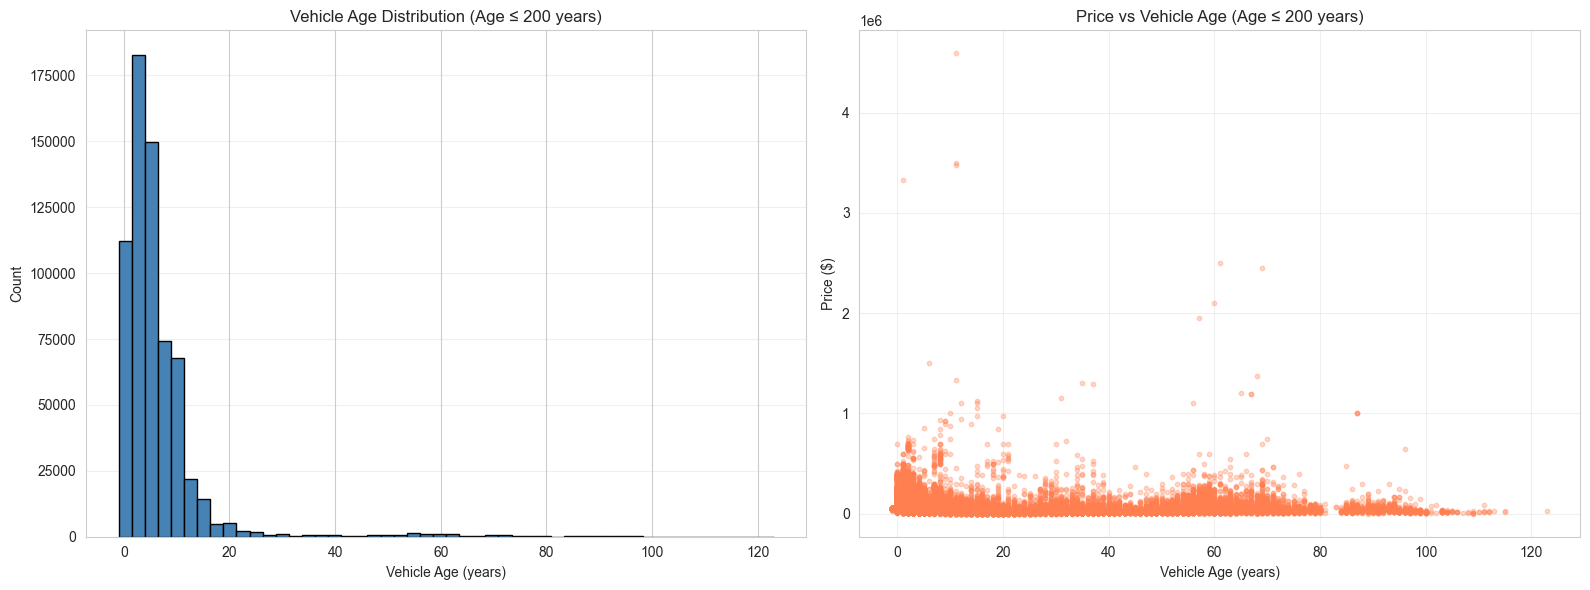

In [180]:
from datetime import datetime
current_year = datetime.now().year
listings['vehicle_age'] = current_year - listings['year']

listings_valid_age = listings[listings['vehicle_age'] <= 200].copy()

invalid_age_count = len(listings[listings['vehicle_age'] > 200])
if invalid_age_count > 0:
    print(f"Note: Filtered out {invalid_age_count:,} vehicles with unrealistic ages (>200 years)")

print("\n" + "="*80)
print("VEHICLE AGE DISTRIBUTION")
print("="*80)
age_stats = listings_valid_age.groupby('vehicle_age').agg({
    'vin': 'count',
    'price': ['mean', 'median'],
    'mileage': ['mean', 'median']
}).round(2)
age_stats.columns = ['Count', 'Avg Price', 'Median Price', 'Avg Mileage', 'Median Mileage']
print(age_stats.sort_index())

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

listings_valid_age['vehicle_age'].hist(bins=50, ax=axes[0], edgecolor='black', color='steelblue')
axes[0].set_xlabel('Vehicle Age (years)')
axes[0].set_ylabel('Count')
axes[0].set_title('Vehicle Age Distribution (Age ≤ 200 years)')
axes[0].grid(axis='y', alpha=0.3)

listings_valid_age.plot.scatter(x='vehicle_age', y='price', ax=axes[1], alpha=0.3, s=10, color='coral')
axes[1].set_xlabel('Vehicle Age (years)')
axes[1].set_ylabel('Price ($)')
axes[1].set_title('Price vs Vehicle Age (Age ≤ 200 years)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [181]:
# ## 12. Make-by-Make Detailed Analysis


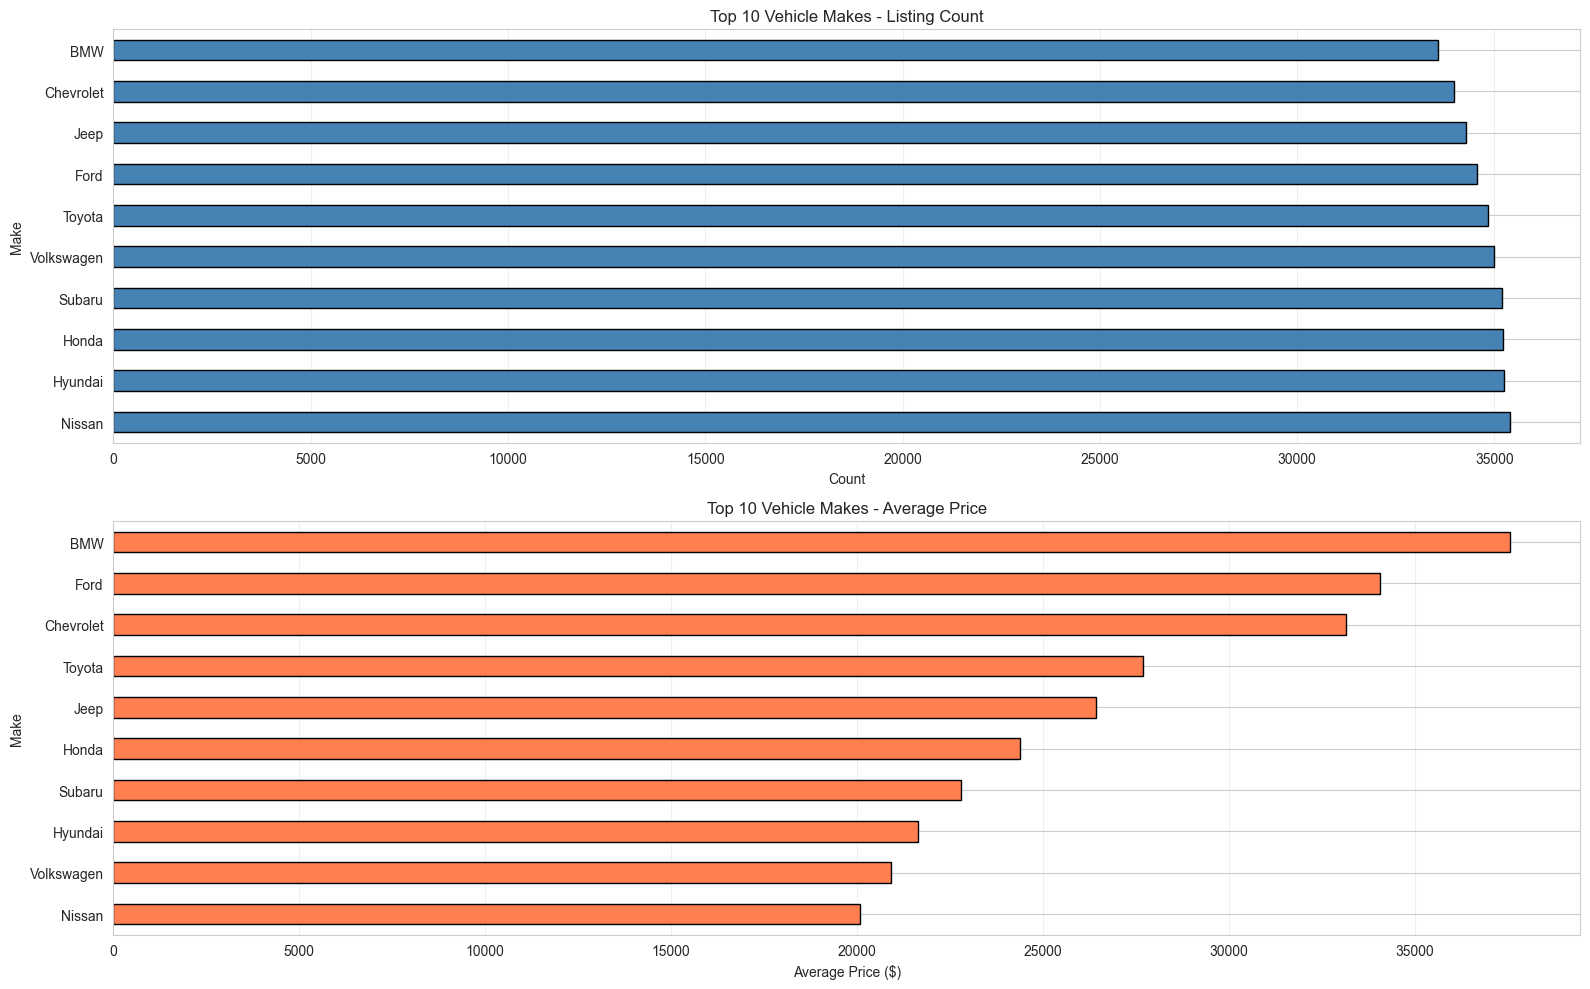

In [182]:
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

top_10_makes = listings['make'].value_counts().head(10).index
make_counts = listings[listings['make'].isin(top_10_makes)]['make'].value_counts()
make_counts.plot(kind='barh', ax=axes[0], color='steelblue', edgecolor='black')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Make')
axes[0].set_title('Top 10 Vehicle Makes - Listing Count')
axes[0].grid(axis='x', alpha=0.3)

make_price = listings[listings['make'].isin(top_10_makes)].groupby('make')['price'].mean().sort_values(ascending=True)
make_price.plot(kind='barh', ax=axes[1], color='coral', edgecolor='black')
axes[1].set_xlabel('Average Price ($)')
axes[1].set_ylabel('Make')
axes[1].set_title('Top 10 Vehicle Makes - Average Price')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()


In [183]:
# ## 13. Price History Trends - 10 Year Old Vehicles (2016 Model Year)



PRICE HISTORY ANALYSIS - 10 YEAR OLD VEHICLES (2016 MODEL YEAR)

Target Model Year: 2016

Total 2016 vehicles with price history: 20,854
Total price history records: 55,880
Date range: 2019-08-20 to 2026-02-14

Nissan:
  Total Records: 2,280
  Total Vehicles: 1,006
  Overall Avg Price: $14,299
  Top 5 Models:
    - Rogue SV: 292 records, avg $12,763
    - Rogue S: 268 records, avg $12,045
    - Rogue SL: 189 records, avg $14,127
    - Frontier SV: 148 records, avg $16,427
    - Altima 2.5 S: 91 records, avg $11,042

Hyundai:
  Total Records: 2,083
  Total Vehicles: 843
  Overall Avg Price: $12,399
  Top 5 Models:
    - TUCSON Limited: 128 records, avg $13,704
    - ELANTRA SE: 111 records, avg $9,916
    - SONATA SE: 109 records, avg $9,390
    - Tucson SE: 107 records, avg $12,528
    - Elantra GT: 103 records, avg $10,479

Honda:
  Total Records: 3,050
  Total Vehicles: 1,468
  Overall Avg Price: $16,035
  Top 5 Models:
    - CR-V EX: 217 records, avg $15,761
    - Civic LX: 213 rec

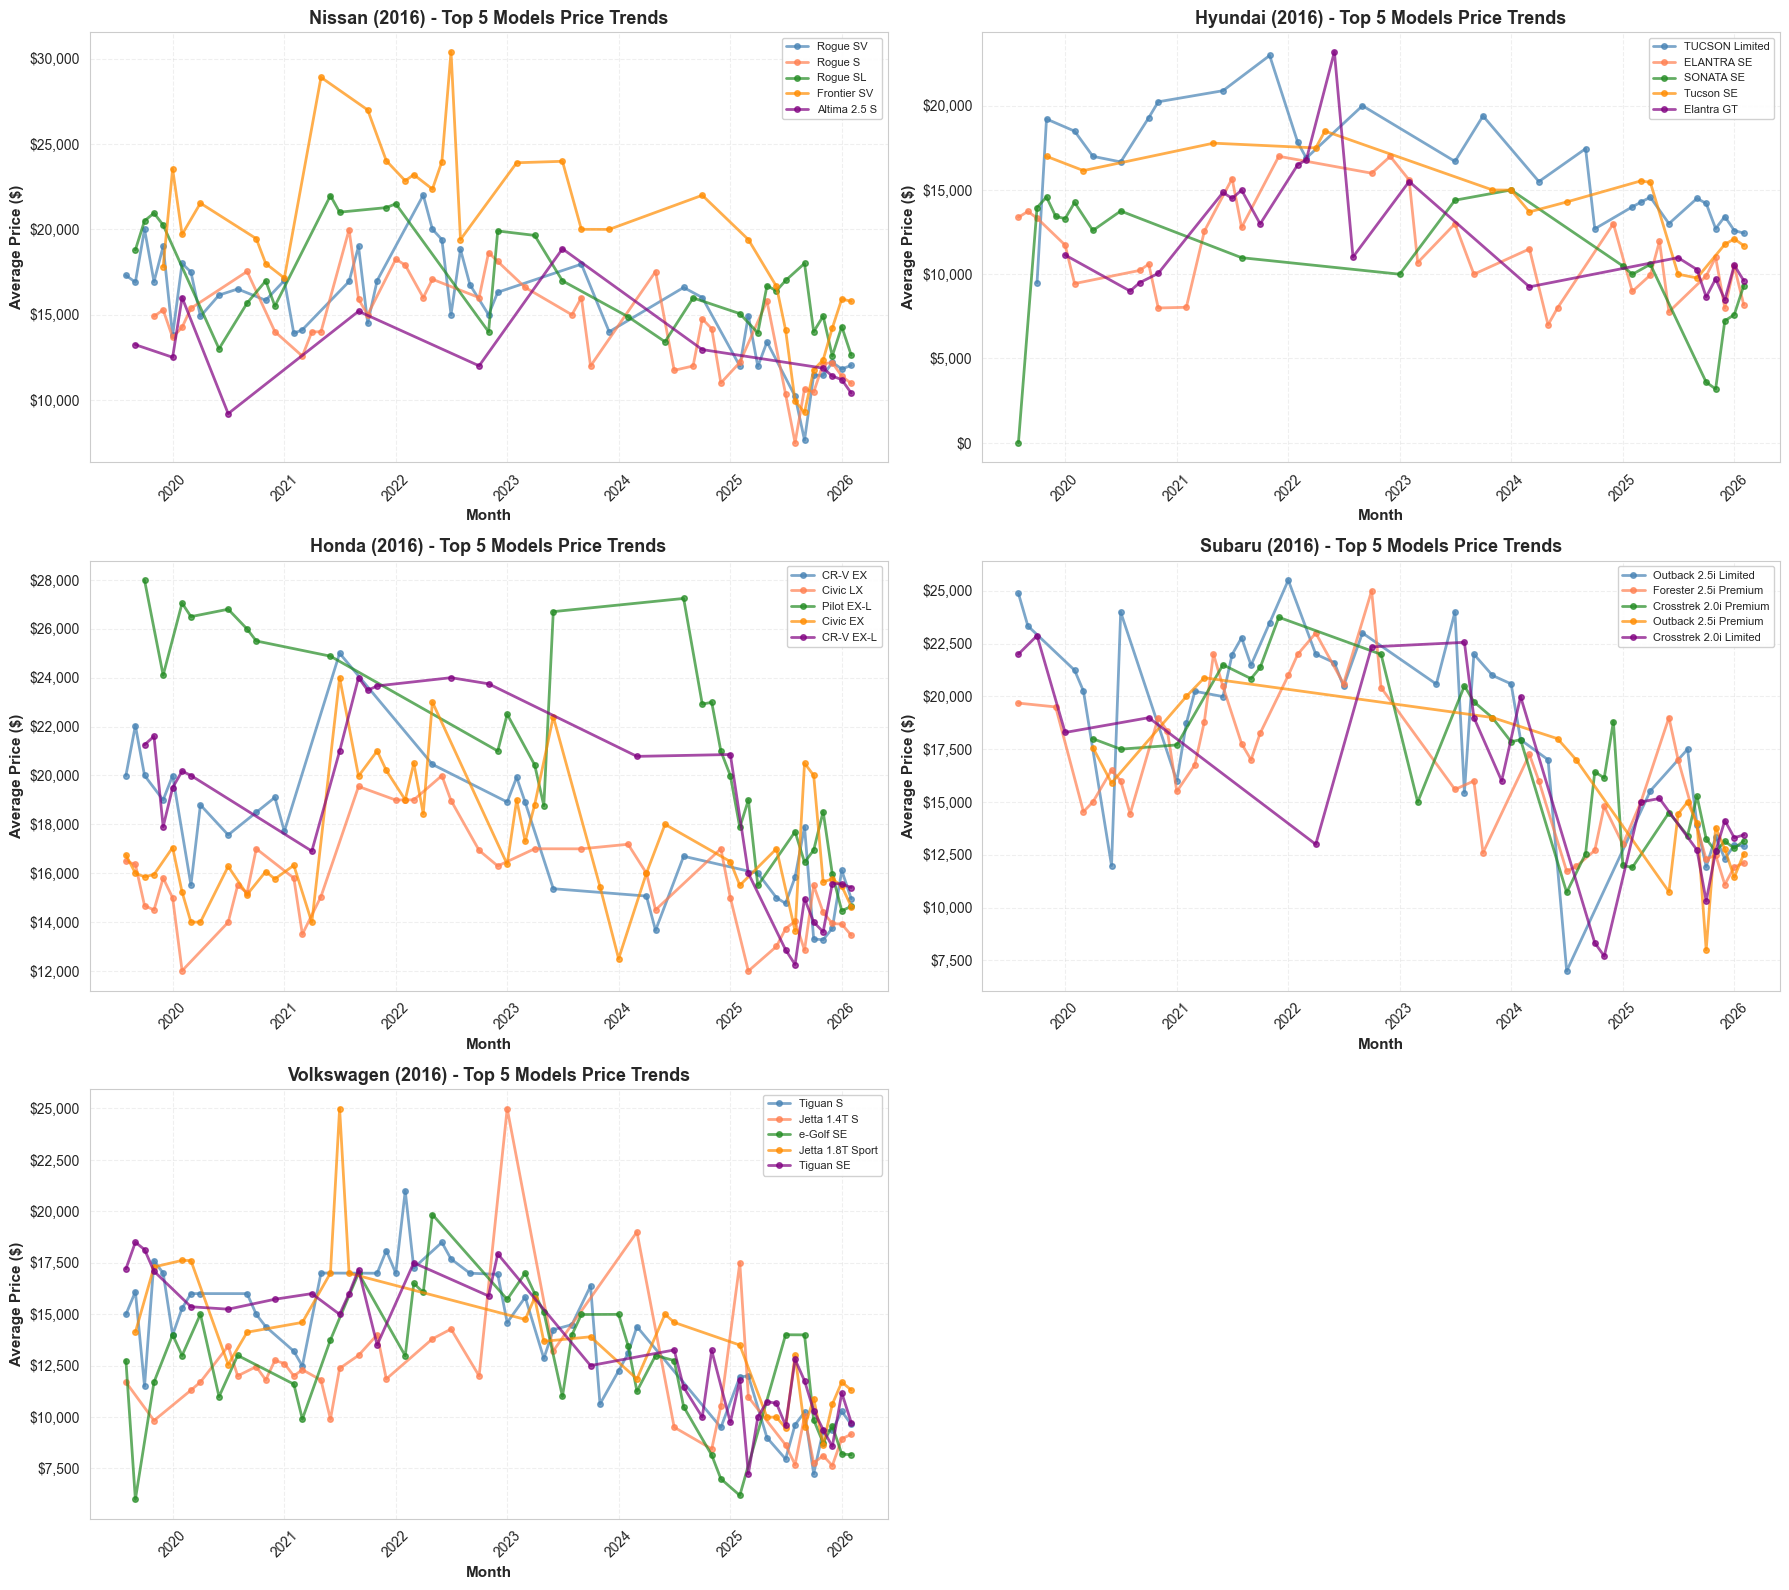

In [184]:
print("\n" + "="*80)
print("PRICE HISTORY ANALYSIS - 10 YEAR OLD VEHICLES (2016 MODEL YEAR)")
print("="*80)

target_year = current_year - 10
print(f"\nTarget Model Year: {int(target_year)}")

top_5_makes_list = listings['make'].value_counts().head(5).index.tolist()

vehicles_2016 = listings[listings['year'] == target_year][['vin', 'make', 'model']].drop_duplicates(subset=['vin'])

price_history_2016 = price_history.merge(
    vehicles_2016,
    on='vin',
    how='inner'
)

price_history_2016['history_date'] = pd.to_datetime(price_history_2016['history_date'])
price_history_2016['year_month'] = price_history_2016['history_date'].dt.to_period('M')

print(f"\nTotal 2016 vehicles with price history: {price_history_2016['vin'].nunique():,}")
print(f"Total price history records: {len(price_history_2016):,}")
print(f"Date range: {price_history_2016['history_date'].min().strftime('%Y-%m-%d')} to {price_history_2016['history_date'].max().strftime('%Y-%m-%d')}")

fig, axes = plt.subplots(3, 2, figsize=(18, 16))
axes = axes.flatten()

for idx, make in enumerate(top_5_makes_list):
    make_data = price_history_2016[price_history_2016['make'] == make]

    ax = axes[idx]

    if len(make_data) > 0:
        top_5_models = make_data['model'].value_counts().head(5).index

        colors_palette = ['steelblue', 'coral', 'forestgreen', 'darkorange', 'purple']

        print(f"\n{make}:")
        print(f"  Total Records: {len(make_data):,}")
        print(f"  Total Vehicles: {make_data['vin'].nunique():,}")
        print(f"  Overall Avg Price: ${make_data['price'].mean():,.0f}")
        print(f"  Top 5 Models:")

        for model_idx, model in enumerate(top_5_models):
            model_data = make_data[make_data['model'] == model]

            if len(model_data) > 0:
                monthly_avg = model_data.groupby('year_month')['price'].mean().sort_index()

                if len(monthly_avg) > 1:
                    monthly_avg.index = monthly_avg.index.to_timestamp()

                    model_label = model[:25] if len(model) > 25 else model
                    ax.plot(monthly_avg.index, monthly_avg.values,
                           marker='o', markersize=4, linewidth=2, alpha=0.7,
                           color=colors_palette[model_idx % len(colors_palette)],
                           label=model_label)

                    print(f"    - {model}: {len(model_data):,} records, avg ${model_data['price'].mean():,.0f}")

        ax.set_xlabel('Month', fontsize=11, fontweight='bold')
        ax.set_ylabel('Average Price ($)', fontsize=11, fontweight='bold')
        ax.set_title(f'{make} (2016) - Top 5 Models Price Trends', fontsize=13, fontweight='bold')
        ax.grid(True, alpha=0.3, linestyle='--')
        ax.legend(loc='best', fontsize=8, framealpha=0.9)
        ax.tick_params(axis='x', rotation=45)
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
    else:
        ax.text(0.5, 0.5, f'No price history data\nfor {make} (2016)',
               ha='center', va='center', fontsize=12, transform=ax.transAxes)
        ax.set_title(f'{make} (2016) - No Data Available', fontsize=13, fontweight='bold')

if len(top_5_makes_list) < 6:
    axes[5].axis('off')

plt.tight_layout()
plt.show()


In [185]:
# ## 14. Comparative Analysis - 2016 Model Year Across Makes



COMPARATIVE PRICE TRENDS - ALL TOP 5 MAKES (2016 MODEL YEAR)


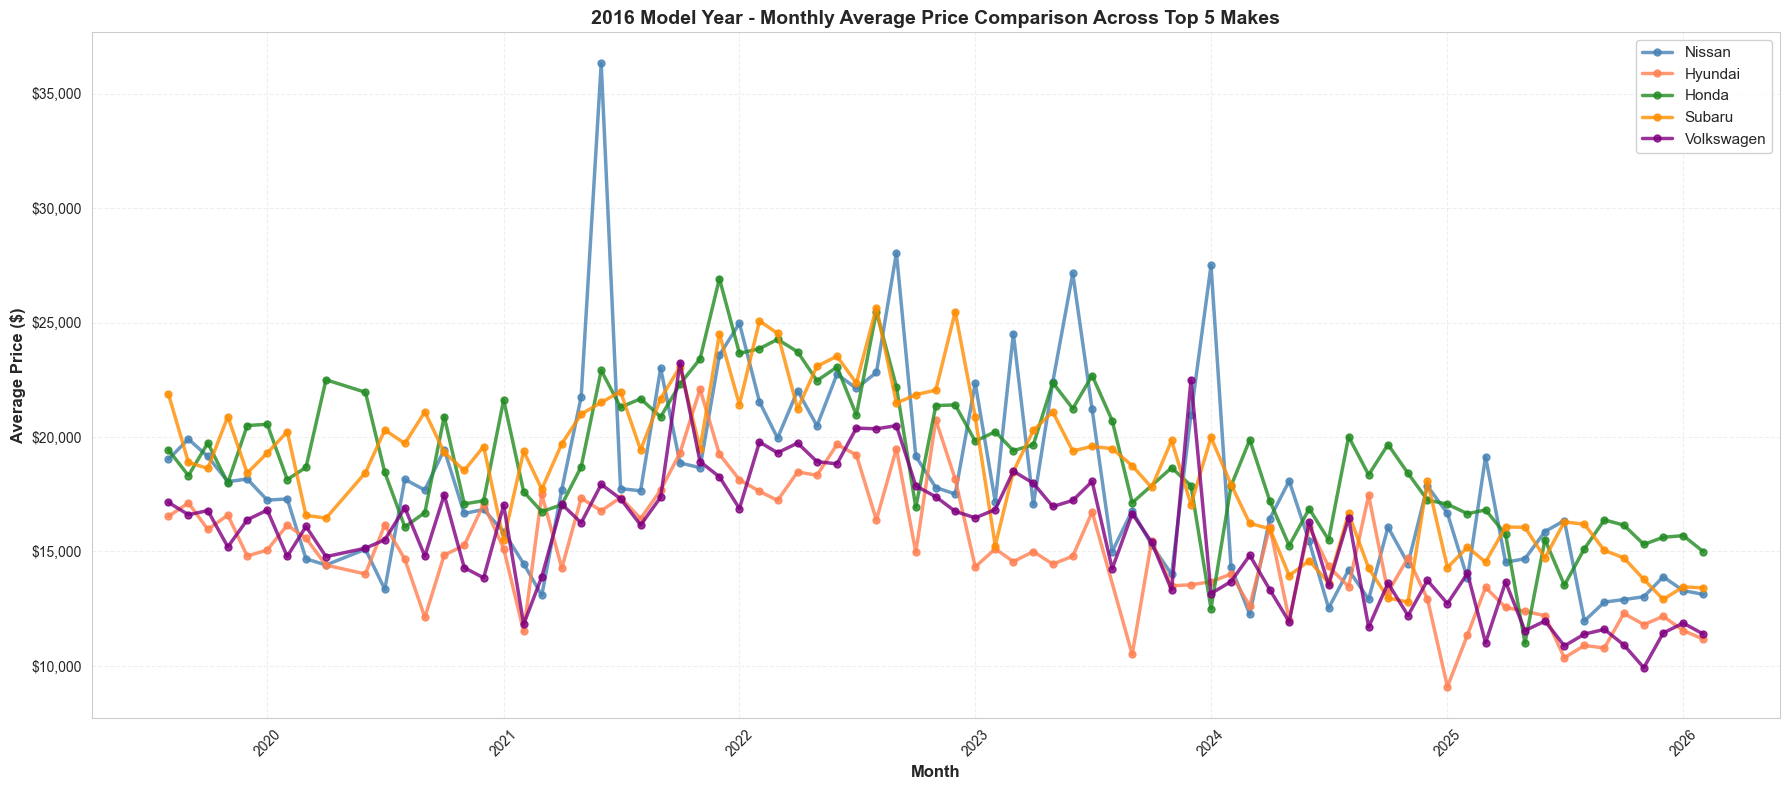


Comparative price trends plotted for all top 5 makes (2016 model year)


In [186]:
print("\n" + "="*80)
print("COMPARATIVE PRICE TRENDS - ALL TOP 5 MAKES (2016 MODEL YEAR)")
print("="*80)

fig, ax = plt.subplots(1, 1, figsize=(18, 8))

colors = ['steelblue', 'coral', 'forestgreen', 'darkorange', 'purple']

for idx, make in enumerate(top_5_makes_list):
    make_data = price_history_2016[price_history_2016['make'] == make]

    if len(make_data) > 0:
        monthly_avg = make_data.groupby('year_month')['price'].mean().sort_index()

        if len(monthly_avg) > 0:
            monthly_avg.index = monthly_avg.index.to_timestamp()

            ax.plot(monthly_avg.index, monthly_avg.values, marker='o', markersize=5,
                   linewidth=2.5, alpha=0.8, color=colors[idx % len(colors)], label=make)

ax.set_xlabel('Month', fontsize=12, fontweight='bold')
ax.set_ylabel('Average Price ($)', fontsize=12, fontweight='bold')
ax.set_title('2016 Model Year - Monthly Average Price Comparison Across Top 5 Makes',
            fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(loc='best', fontsize=11, framealpha=0.9)
ax.tick_params(axis='x', rotation=45)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

plt.tight_layout()
plt.show()

print("\nComparative price trends plotted for all top 5 makes (2016 model year)")


In [187]:
# ## 15. Monthly Statistics - 2016 Model Year


In [188]:
print("\n" + "="*80)
print("MONTHLY PRICE STATISTICS - 2016 MODEL YEAR (ALL MAKES)")
print("="*80)

if len(price_history_2016) > 0:
    monthly_stats = price_history_2016.groupby('year_month').agg({
        'price': ['count', 'mean', 'median', 'std', 'min', 'max'],
        'vin': 'nunique'
    }).round(2)

    monthly_stats.columns = ['Records', 'Avg Price', 'Median Price', 'Std Dev', 'Min Price', 'Max Price', 'Unique Vehicles']
    monthly_stats.index = monthly_stats.index.to_timestamp()
    monthly_stats = monthly_stats.sort_index(ascending=False).head(12)

    print("\nLast 12 Months of Data:")
    print(monthly_stats.to_string())
else:
    print("\nNo price history data available for 2016 model year vehicles")



MONTHLY PRICE STATISTICS - 2016 MODEL YEAR (ALL MAKES)

Last 12 Months of Data:
            Records  Avg Price  Median Price   Std Dev  Min Price  Max Price  Unique Vehicles
year_month                                                                                   
2026-02-01    16481   16769.08       14647.0  14632.48        999     799995            12755
2026-01-01    15406   17718.37       14995.0  18703.18       1200     899995             9883
2025-12-01     5174   18061.96       14995.0  16238.75       1225     369800             3698
2025-11-01     2336   18704.70       14996.0  28462.48       2000     839900             1826
2025-10-01     1463   18518.96       15253.0  17053.63       1569     259900             1151
2025-09-01      940   19376.10       15495.0  19165.99       1590     319500              767
2025-08-01      706   21542.71       14998.5  45093.99       3724    1000803              573
2025-07-01      564   21116.48       15509.0  31288.45       4288     329

In [189]:
# ## 16. NHTSA Safety & Recall Analysis


In [190]:
# Merge with NHTSA enrichment - using safety equipment features (more likely to have data)
safety_feature_cols = ['vin', 'nhtsa_Make', 'nhtsa_Model', 'nhtsa_ModelYear', 'nhtsa_BasePrice', 'nhtsa_BodyClass',
                       'nhtsa_ABS', 'nhtsa_ESC', 'nhtsa_TPMS', 'nhtsa_EDR',
                       'nhtsa_AirBagLocFront', 'nhtsa_AirBagLocSide', 'nhtsa_AirBagLocCurtain',
                       'nhtsa_BlindSpotMon', 'nhtsa_ForwardCollisionWarning', 'nhtsa_LaneDepartureWarning',
                       'nhtsa_AdaptiveCruiseControl', 'nhtsa_ParkAssist', 'nhtsa_RearVisibilitySystem',
                       'nhtsa_PedestrianAutomaticEmergencyBraking', 'nhtsa_RearCrossTrafficAlert']

# Check which columns actually exist in nhtsa_enrichment
available_cols = ['vin']  # Always include vin
for col in safety_feature_cols[1:]:  # Skip 'vin' as we already added it
    if col in nhtsa_enrichment.columns:
        available_cols.append(col)

listings_enriched = listings.merge(
    nhtsa_enrichment[available_cols],
    on='vin',
    how='left'
)

# Convert BasePrice to numeric if it exists
if 'nhtsa_BasePrice' in listings_enriched.columns:
    listings_enriched['nhtsa_BasePrice'] = pd.to_numeric(listings_enriched['nhtsa_BasePrice'], errors='coerce')

print("\n" + "="*80)
print("SAFETY ANALYSIS - SAFETY EQUIPMENT FEATURES BY MAKE")
print("="*80)

# Define safety equipment features to analyze
safety_features = {
    'nhtsa_ABS': 'Anti-Lock Brakes (ABS)',
    'nhtsa_ESC': 'Electronic Stability Control (ESC)',
    'nhtsa_TPMS': 'Tire Pressure Monitoring System (TPMS)',
    'nhtsa_BlindSpotMon': 'Blind Spot Monitoring',
    'nhtsa_ForwardCollisionWarning': 'Forward Collision Warning',
    'nhtsa_LaneDepartureWarning': 'Lane Departure Warning',
    'nhtsa_AdaptiveCruiseControl': 'Adaptive Cruise Control',
    'nhtsa_RearVisibilitySystem': 'Rear Camera/Visibility System',
    'nhtsa_PedestrianAutomaticEmergencyBraking': 'Pedestrian Emergency Braking'
}

# Check which features have data and calculate adoption rates by make
feature_data = []
for feature_col, feature_name in safety_features.items():
    if feature_col in listings_enriched.columns:
        # Count vehicles with this feature (where value is not null/empty and not "Not Equipped")
        has_feature = listings_enriched[
            (listings_enriched[feature_col].notna()) &
            (listings_enriched[feature_col] != '') &
            (~listings_enriched[feature_col].str.contains('Not', case=False, na=False))
        ]

        total_with_data = listings_enriched[listings_enriched[feature_col].notna()].shape[0]
        equipped_count = has_feature.shape[0]

        if total_with_data > 0:
            adoption_rate = (equipped_count / total_with_data * 100)
            feature_data.append({
                'Feature': feature_name,
                'Vehicles Equipped': equipped_count,
                'Total with Data': total_with_data,
                'Adoption Rate %': round(adoption_rate, 2)
            })

if feature_data:
    safety_features_df = pd.DataFrame(feature_data).sort_values('Adoption Rate %', ascending=False)
    print("\nSafety Feature Adoption Rates:")
    print(safety_features_df.to_string(index=False))

    # Analyze by make for top features
    print("\n" + "="*80)
    print("SAFETY FEATURES BY MAKE (TOP 10 MAKES)")
    print("="*80)

    top_makes = listings_enriched['make'].value_counts().head(10).index

    for feature_col, feature_name in list(safety_features.items())[:5]:  # Show top 5 features
        if feature_col in listings_enriched.columns:
            print(f"\n{feature_name}:")

            make_feature_stats = []
            for make in top_makes:
                make_data = listings_enriched[listings_enriched['make'] == make]
                total_make = make_data[make_data[feature_col].notna()].shape[0]

                if total_make > 0:
                    equipped = make_data[
                        (make_data[feature_col].notna()) &
                        (make_data[feature_col] != '') &
                        (~make_data[feature_col].str.contains('Not', case=False, na=False))
                    ].shape[0]

                    rate = (equipped / total_make * 100)
                    make_feature_stats.append({'Make': make, 'Equipped %': round(rate, 1), 'Count': equipped})

            if make_feature_stats:
                feature_by_make_df = pd.DataFrame(make_feature_stats).sort_values('Equipped %', ascending=False)
                print(feature_by_make_df.to_string(index=False))
else:
    print("\n✗ No safety equipment feature data available in NHTSA enrichment table")
    print("The NHTSA VIN decoding provides vehicle specifications including safety equipment.")

print("\n" + "="*80)
print("SAFETY ANALYSIS - AIRBAG COVERAGE BY MAKE")
print("="*80)

airbag_cols = {
    'nhtsa_AirBagLocFront': 'Front Airbags',
    'nhtsa_AirBagLocSide': 'Side Airbags',
    'nhtsa_AirBagLocCurtain': 'Curtain Airbags'
}

airbag_data = []
for airbag_col, airbag_name in airbag_cols.items():
    if airbag_col in listings_enriched.columns:
        total_with_airbag = listings_enriched[
            (listings_enriched[airbag_col].notna()) &
            (listings_enriched[airbag_col] != '')
        ].shape[0]

        total_records = listings_enriched.shape[0]
        coverage = (total_with_airbag / total_records * 100) if total_records > 0 else 0

        airbag_data.append({
            'Airbag Type': airbag_name,
            'Vehicles with Data': total_with_airbag,
            'Coverage %': round(coverage, 2)
        })

if airbag_data:
    airbag_df = pd.DataFrame(airbag_data)
    print("\nAirbag System Coverage:")
    print(airbag_df.to_string(index=False))
else:
    print("\n✗ No airbag data available")



SAFETY ANALYSIS - SAFETY EQUIPMENT FEATURES BY MAKE

Safety Feature Adoption Rates:
                               Feature  Vehicles Equipped  Total with Data  Adoption Rate %
Tire Pressure Monitoring System (TPMS)             545410           646844            84.32
                Anti-Lock Brakes (ABS)             509947           646844            78.84
    Electronic Stability Control (ESC)             477055           646844            73.75
         Rear Camera/Visibility System             474263           646844            73.32
             Forward Collision Warning             426397           646844            65.92
                Lane Departure Warning             406705           646844            62.88
                 Blind Spot Monitoring             403622           646844            62.40
               Adaptive Cruise Control             341453           646844            52.79
          Pedestrian Emergency Braking             302932           646844            4

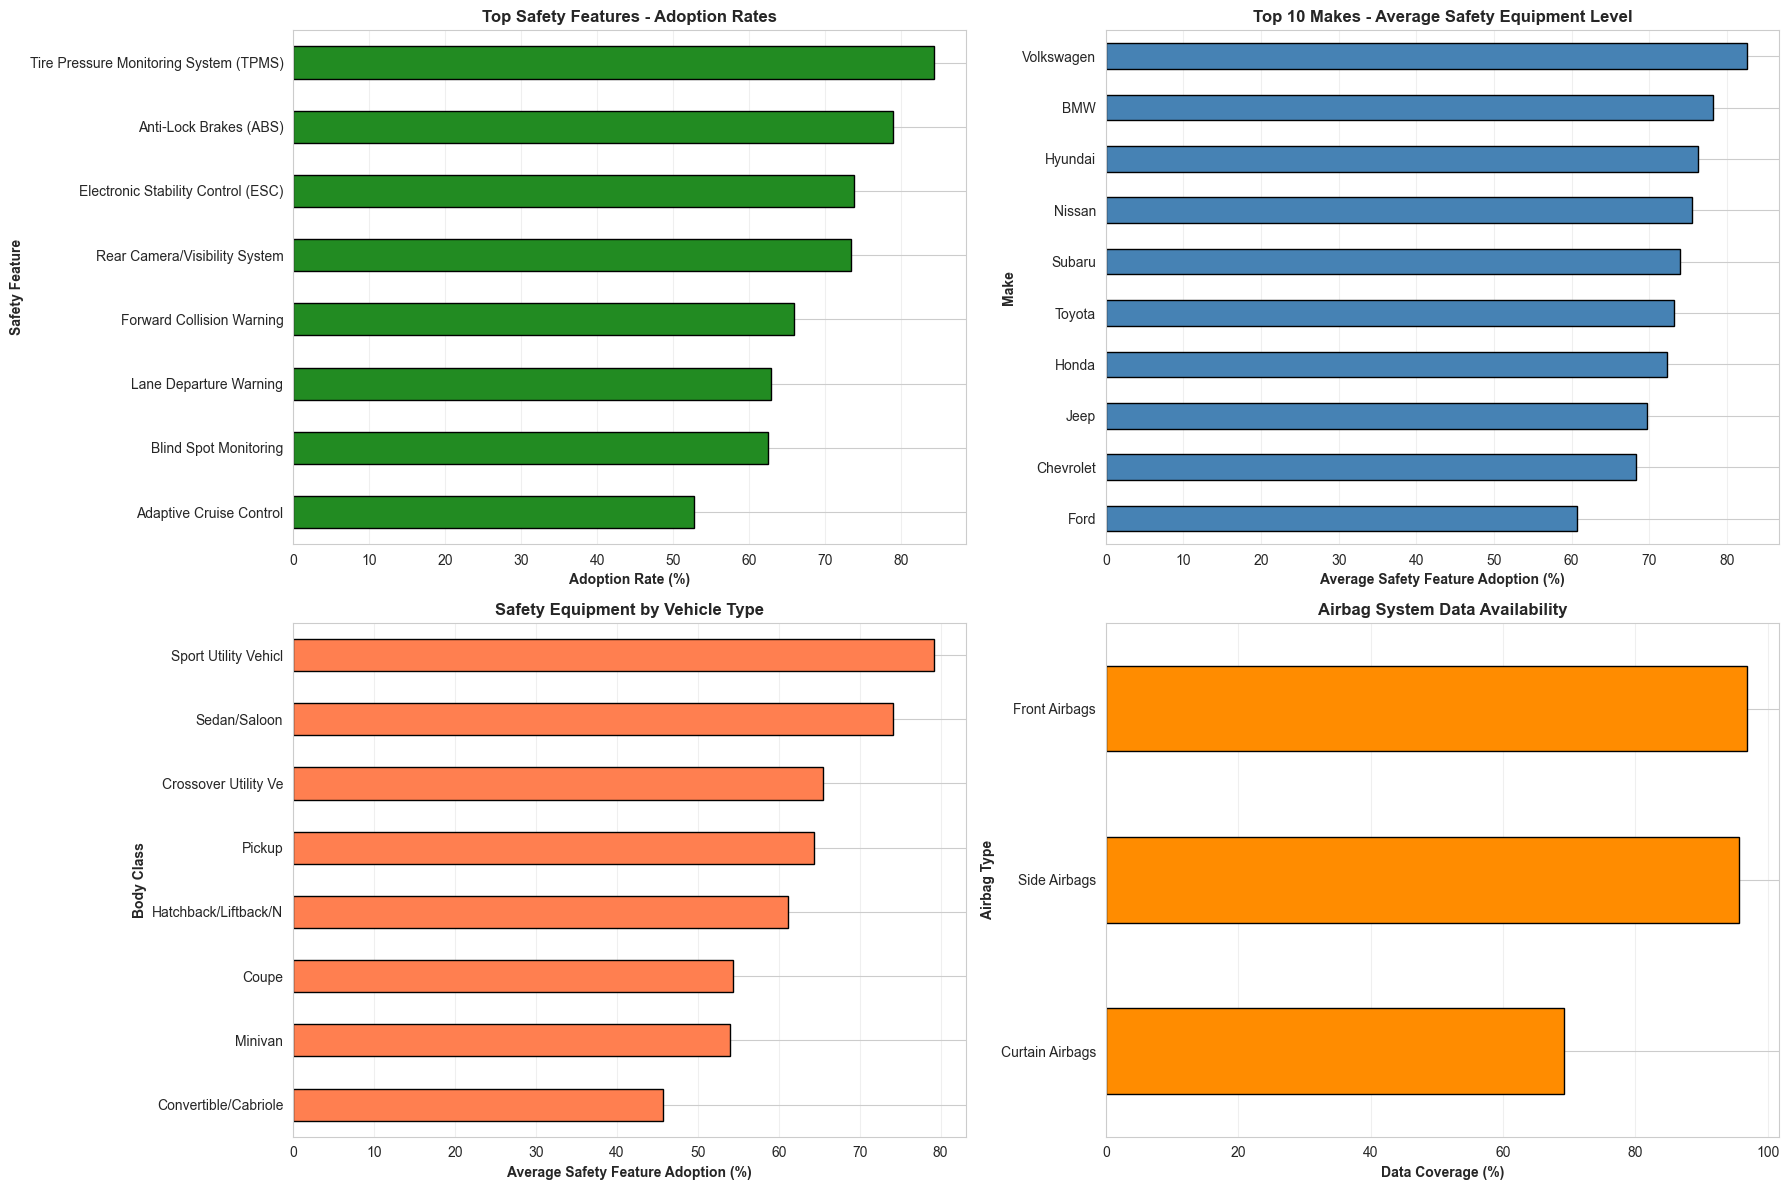


NHTSA SAFETY DATA SUMMARY
Safety feature data: ✓ Available
Airbag data: ✓ Available
Body class data: ✓ Available

Note: This analysis uses NHTSA vehicle specification data (safety equipment)
rather than crash test ratings, which are often unavailable in the vPIC API.


In [192]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Chart 1: Safety Feature Adoption Rates (Overall)
if 'safety_features_df' in locals() and len(safety_features_df) > 0:
    top_features = safety_features_df.head(8).sort_values('Adoption Rate %', ascending=True)
    top_features.plot(x='Feature', y='Adoption Rate %', kind='barh', ax=axes[0, 0],
                     color='forestgreen', edgecolor='black', legend=False)
    axes[0, 0].set_xlabel('Adoption Rate (%)', fontweight='bold')
    axes[0, 0].set_ylabel('Safety Feature', fontweight='bold')
    axes[0, 0].set_title('Top Safety Features - Adoption Rates', fontweight='bold')
    axes[0, 0].grid(axis='x', alpha=0.3)
else:
    axes[0, 0].text(0.5, 0.5, 'No safety feature data available\n(NHTSA enrichment needed)',
                   ha='center', va='center', transform=axes[0, 0].transAxes, fontsize=12)
    axes[0, 0].set_title('Safety Features - No Data', fontweight='bold')

# Chart 2: Top 10 Makes - Safety Feature Equipped (Best Average)
top_makes = listings_enriched['make'].value_counts().head(10).index
make_safety_scores = []

for make in top_makes:
    make_data = listings_enriched[listings_enriched['make'] == make]
    total_features_equipped = 0
    total_features_checked = 0

    for feature_col in list(safety_features.keys())[:5]:  # Top 5 features
        if feature_col in listings_enriched.columns:
            total = make_data[make_data[feature_col].notna()].shape[0]
            if total > 0:
                equipped = make_data[
                    (make_data[feature_col].notna()) &
                    (make_data[feature_col] != '') &
                    (~make_data[feature_col].str.contains('Not', case=False, na=False))
                ].shape[0]
                total_features_equipped += equipped
                total_features_checked += total

    if total_features_checked > 0:
        avg_rate = (total_features_equipped / total_features_checked * 100)
        make_safety_scores.append({'Make': make, 'Avg Feature Rate': avg_rate})

if make_safety_scores:
    make_safety_df = pd.DataFrame(make_safety_scores).sort_values('Avg Feature Rate', ascending=True)
    make_safety_df.plot(x='Make', y='Avg Feature Rate', kind='barh', ax=axes[0, 1],
                       color='steelblue', edgecolor='black', legend=False)
    axes[0, 1].set_xlabel('Average Safety Feature Adoption (%)', fontweight='bold')
    axes[0, 1].set_ylabel('Make', fontweight='bold')
    axes[0, 1].set_title('Top 10 Makes - Average Safety Equipment Level', fontweight='bold')
    axes[0, 1].grid(axis='x', alpha=0.3)
else:
    axes[0, 1].text(0.5, 0.5, 'No safety feature data by make',
                   ha='center', va='center', transform=axes[0, 1].transAxes, fontsize=12)
    axes[0, 1].set_title('Safety by Make - No Data', fontweight='bold')

# Chart 3: Body Class Safety Feature Adoption
if 'nhtsa_BodyClass' in listings_enriched.columns:
    body_class_data = []
    top_body_classes = listings_enriched['nhtsa_BodyClass'].value_counts().head(8).index

    for body_class in top_body_classes:
        class_data = listings_enriched[listings_enriched['nhtsa_BodyClass'] == body_class]
        total_features = 0
        total_checked = 0

        for feature_col in list(safety_features.keys())[:5]:
            if feature_col in listings_enriched.columns:
                total = class_data[class_data[feature_col].notna()].shape[0]
                if total > 0:
                    equipped = class_data[
                        (class_data[feature_col].notna()) &
                        (class_data[feature_col] != '') &
                        (~class_data[feature_col].str.contains('Not', case=False, na=False))
                    ].shape[0]
                    total_features += equipped
                    total_checked += total

        if total_checked > 0:
            rate = (total_features / total_checked * 100)
            body_class_data.append({'Body Class': body_class[:20], 'Rate': rate})

    if body_class_data:
        body_df = pd.DataFrame(body_class_data).sort_values('Rate', ascending=True)
        body_df.plot(x='Body Class', y='Rate', kind='barh', ax=axes[1, 0],
                    color='coral', edgecolor='black', legend=False)
        axes[1, 0].set_xlabel('Average Safety Feature Adoption (%)', fontweight='bold')
        axes[1, 0].set_ylabel('Body Class', fontweight='bold')
        axes[1, 0].set_title('Safety Equipment by Vehicle Type', fontweight='bold')
        axes[1, 0].grid(axis='x', alpha=0.3)
    else:
        axes[1, 0].text(0.5, 0.5, 'Insufficient body class data',
                       ha='center', va='center', transform=axes[1, 0].transAxes, fontsize=12)
        axes[1, 0].set_title('Safety by Type - No Data', fontweight='bold')
else:
    axes[1, 0].text(0.5, 0.5, 'No body class data available',
                   ha='center', va='center', transform=axes[1, 0].transAxes, fontsize=12)
    axes[1, 0].set_title('Safety by Type - No Data', fontweight='bold')

# Chart 4: Airbag Coverage Summary
if airbag_data:
    airbag_chart_df = pd.DataFrame(airbag_data).sort_values('Coverage %', ascending=True)
    airbag_chart_df.plot(x='Airbag Type', y='Coverage %', kind='barh', ax=axes[1, 1],
                        color='darkorange', edgecolor='black', legend=False)
    axes[1, 1].set_xlabel('Data Coverage (%)', fontweight='bold')
    axes[1, 1].set_ylabel('Airbag Type', fontweight='bold')
    axes[1, 1].set_title('Airbag System Data Availability', fontweight='bold')
    axes[1, 1].grid(axis='x', alpha=0.3)
else:
    axes[1, 1].text(0.5, 0.5, 'No airbag data available',
                   ha='center', va='center', transform=axes[1, 1].transAxes, fontsize=12)
    axes[1, 1].set_title('Airbag Data - Not Available', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("NHTSA SAFETY DATA SUMMARY")
print("="*80)
print(f"Safety feature data: {'✓ Available' if feature_data else '✗ Not available'}")
print(f"Airbag data: {'✓ Available' if airbag_data else '✗ Not available'}")
print(f"Body class data: {'✓ Available' if 'nhtsa_BodyClass' in listings_enriched.columns else '✗ Not available'}")
print("\nNote: This analysis uses NHTSA vehicle specification data (safety equipment)")
print("rather than crash test ratings, which are often unavailable in the vPIC API.")


In [ ]:
# ## 17. Residual Value Analysis - Best Value Retention


In [193]:
print("\n" + "="*80)
print("RESIDUAL VALUE ANALYSIS - DATA AVAILABILITY CHECK")
print("="*80)

listings_residual = listings_enriched.copy()

listings_residual['nhtsa_BasePrice'] = pd.to_numeric(listings_residual['nhtsa_BasePrice'], errors='coerce')

print("\nChecking NHTSA BasePrice availability by year:")
baseprice_avail = listings_residual.groupby('year').agg({
    'vin': 'count',
    'nhtsa_BasePrice': lambda x: x.notna().sum()
})
baseprice_avail.columns = ['Total Vehicles', 'With BasePrice']
baseprice_avail['% With BasePrice'] = (baseprice_avail['With BasePrice'] / baseprice_avail['Total Vehicles'] * 100).round(2)
baseprice_avail = baseprice_avail[baseprice_avail['Total Vehicles'] >= 100].sort_index(ascending=False).head(20)
print(baseprice_avail)

candidate_years = baseprice_avail[baseprice_avail['% With BasePrice'] >= 10.0].index.tolist()
print(f"\nYears with ≥10% BasePrice coverage: {candidate_years}")

age_groups = []
for years_old in [5, 10, 15]:
    target_year = current_year - years_old
    if target_year in candidate_years:
        age_groups.append((years_old, target_year))
        print(f"  ✓ Using {int(target_year)} for {years_old}-year-old analysis")
    else:
        print(f"  ✗ Skipping {years_old}-year-old analysis - {int(target_year)} has insufficient BasePrice data")

if not age_groups:
    print("\n⚠ WARNING: No suitable years found with BasePrice data for residual value analysis")
    print("NHTSA enrichment may need to be run for older vehicles")
else:
    print("\n" + "="*80)
    print("RESIDUAL VALUE ANALYSIS")
    print("="*80)

    listings_residual['residual_value'] = listings_residual['price'] - listings_residual['nhtsa_BasePrice']
    listings_residual['residual_pct'] = (listings_residual['price'] / listings_residual['nhtsa_BasePrice'] * 100).round(2)

    listings_residual = listings_residual[
        (listings_residual['nhtsa_BasePrice'].notna()) &
        (listings_residual['nhtsa_BasePrice'] > 0) &
        (listings_residual['price'] > 0)
    ]

    for years_old, target_year_val in age_groups:
        print("\n" + "="*80)
        print(f"TOP 10 MAKES - BEST RESIDUAL VALUE ({years_old} YEAR OLD VEHICLES - {int(target_year_val)} MODEL YEAR)")
        print("="*80)
        print(f"\nCALCULATION METHODOLOGY:")
        print(f"  Model Year Being Analyzed: {int(target_year_val)}")
        print(f"  Base Price: Original MSRP from NHTSA for {int(target_year_val)} model year")
        print(f"  Current Price: Market price in 2026 for {int(target_year_val)} model year vehicles")
        print(f"  Age at Evaluation: {years_old} years old (manufactured in {int(target_year_val)}, evaluated in 2026)")
        print(f"  Residual % = (Current Market Price of {int(target_year_val)} vehicles / Original {int(target_year_val)} MSRP) × 100")
        print("-" * 80)

        age_data = listings_residual[listings_residual['year'] == target_year_val].copy()

        if len(age_data) > 0:
            print(f"\nData Summary:")
            print(f"  Total {int(target_year_val)} model year vehicles with pricing data: {len(age_data):,}")
            print(f"  Average current market price (2026) for {int(target_year_val)} vehicles: ${age_data['price'].mean():,.0f}")
            print(f"  Average original base price for {int(target_year_val)} vehicles: ${age_data['nhtsa_BasePrice'].mean():,.0f}")
            print(f"  Overall residual value: {(age_data['price'].mean() / age_data['nhtsa_BasePrice'].mean() * 100):.1f}%")

            residual_by_make = age_data.groupby('make').agg({
                'year': 'first',
                'residual_pct': 'mean',
                'price': 'mean',
                'nhtsa_BasePrice': 'mean',
                'vin': 'count'
            }).round(2)
            residual_by_make.columns = ['Model Year', 'Avg Residual %', f'Avg Current Price ({int(target_year_val)} in 2026)', f'Avg Base Price ({int(target_year_val)} MSRP)', 'Vehicle Count']
            residual_by_make = residual_by_make[residual_by_make['Vehicle Count'] >= 5]
            residual_by_make = residual_by_make.sort_values('Avg Residual %', ascending=False).head(10)

            print(f"\nTOP 10 MAKES BY RESIDUAL VALUE:")
            print(residual_by_make.to_string())

            print(f"\nTOP 10 MODELS - BEST RESIDUAL VALUE ({years_old} YEAR OLD VEHICLES):")

            residual_by_model = age_data.groupby(['make', 'model']).agg({
                'year': 'first',
                'residual_pct': 'mean',
                'price': 'mean',
                'nhtsa_BasePrice': 'mean',
                'vin': 'count'
            }).round(2)
            residual_by_model.columns = ['Model Year', 'Avg Residual %', f'Avg Current Price ({int(target_year_val)} in 2026)', f'Avg Base Price ({int(target_year_val)} MSRP)', 'Vehicle Count']
            residual_by_model = residual_by_model[residual_by_model['Vehicle Count'] >= 3]
            residual_by_model = residual_by_model.sort_values('Avg Residual %', ascending=False).head(10)

            print(residual_by_model.to_string())
        else:
            print(f"\nNo data available for {int(target_year_val)} model year vehicles with base price information")



RESIDUAL VALUE ANALYSIS - DATA AVAILABILITY CHECK

Checking NHTSA BasePrice availability by year:
      Total Vehicles  With BasePrice  % With BasePrice
year                                                  
2027             108               0              0.00
2026           25856               0              0.00
2025           86328               0              0.00
2024           84476               0              0.00
2023           98435               1              0.00
2022           62363               0              0.00
2021           46747            8868             18.97
2020           40687           14336             35.23
2019           40515           20135             49.70
2018           33866           24343             71.88
2017           27831           17229             61.91
2016           22043               0              0.00
2015           18035               0              0.00
2014           12552               0              0.00
2013            9374 

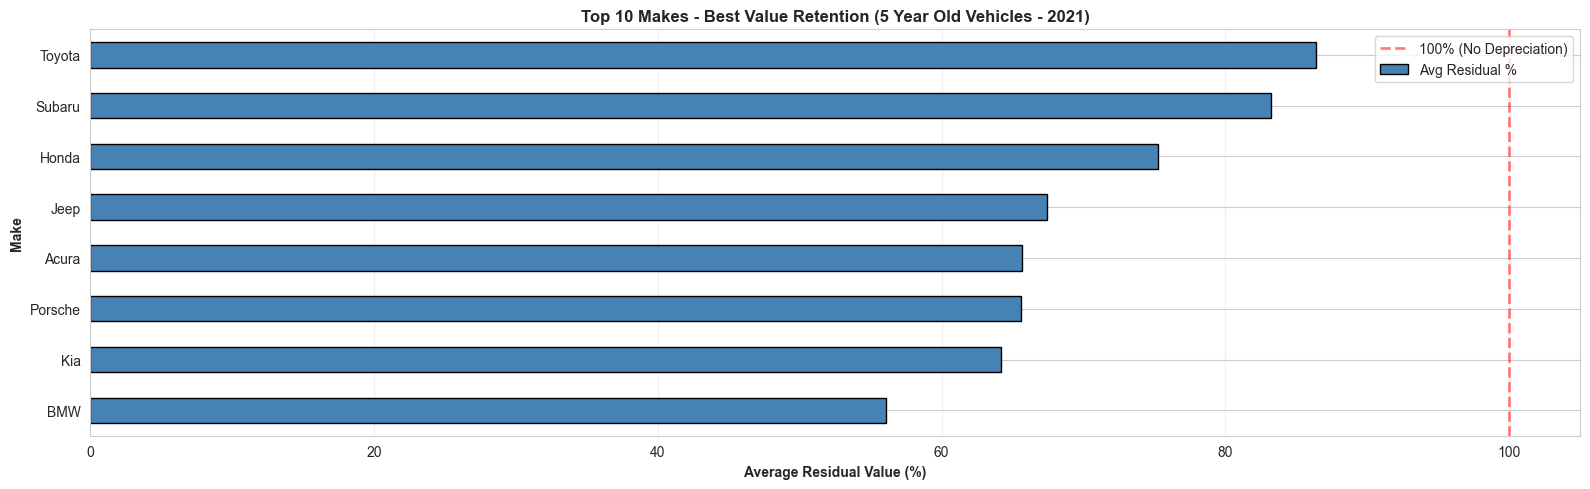

In [194]:
if age_groups:
    num_charts = len(age_groups)
    fig, axes = plt.subplots(num_charts, 1, figsize=(16, 5 * num_charts))

    if num_charts == 1:
        axes = [axes]

    for idx, (years_old, target_year_val) in enumerate(age_groups):
        age_data = listings_residual[listings_residual['year'] == target_year_val].copy()

        if len(age_data) > 0:
            residual_by_make = age_data.groupby('make').agg({
                'residual_pct': 'mean',
                'vin': 'count'
            }).round(2)
            residual_by_make.columns = ['Avg Residual %', 'Vehicle Count']
            residual_by_make = residual_by_make[residual_by_make['Vehicle Count'] >= 5]
            top_10_residual = residual_by_make.sort_values('Avg Residual %', ascending=False).head(10).sort_values('Avg Residual %', ascending=True)

            top_10_residual['Avg Residual %'].plot(kind='barh', ax=axes[idx], color='steelblue', edgecolor='black')
            axes[idx].set_xlabel('Average Residual Value (%)', fontweight='bold')
            axes[idx].set_ylabel('Make', fontweight='bold')
            axes[idx].set_title(f'Top 10 Makes - Best Value Retention ({years_old} Year Old Vehicles - {int(target_year_val)})', fontweight='bold', fontsize=12)
            axes[idx].grid(axis='x', alpha=0.3)
            axes[idx].axvline(x=100, color='red', linestyle='--', linewidth=2, alpha=0.5, label='100% (No Depreciation)')
            axes[idx].legend()
        else:
            axes[idx].text(0.5, 0.5, f'No data for {int(target_year_val)} model year', ha='center', va='center', transform=axes[idx].transAxes, fontsize=14)
            axes[idx].set_title(f'{years_old} Year Old Vehicles - No Data Available', fontweight='bold')

    plt.tight_layout()
    plt.show()
else:
    print("\n⚠ No residual value charts generated - insufficient BasePrice data in NHTSA enrichment")


In [195]:
# ## 18. Summary Insights


In [ ]:
# ## 19. Geographic Distribution - US Map Visualization



GEOGRAPHIC DISTRIBUTION OF LISTINGS

Total listings with valid zip codes: 626,769
Unique zip codes: 7,566

Top 15 Zip Codes by Listing Count:
zip_code  Listing Count  Avg Price  Avg Mileage  Top Make
   33844           2899   24783.22     36086.57 Chevrolet
   33612           2696   29453.91     57550.69      Ford
   23834           2646   24098.17     52707.81 Chevrolet
   44053           2074   23650.08     52188.69 Chevrolet
   28027           2022   28453.76     49672.14 Chevrolet
   95765           2022   23337.15     40087.48 Chevrolet
   46140           1786   24925.44     51425.50 Chevrolet
   77074           1748   37285.66     51793.26     Lexus
   55077           1741   37717.15     23181.27     Honda
   85353           1714   24383.42     43243.22 Chevrolet
   33157           1654   27638.98     46957.57     Honda
   75093           1638   38082.40     42127.64       BMW
   30096           1593   33860.84     47558.72       BMW
   32809           1543   21305.69     64675.

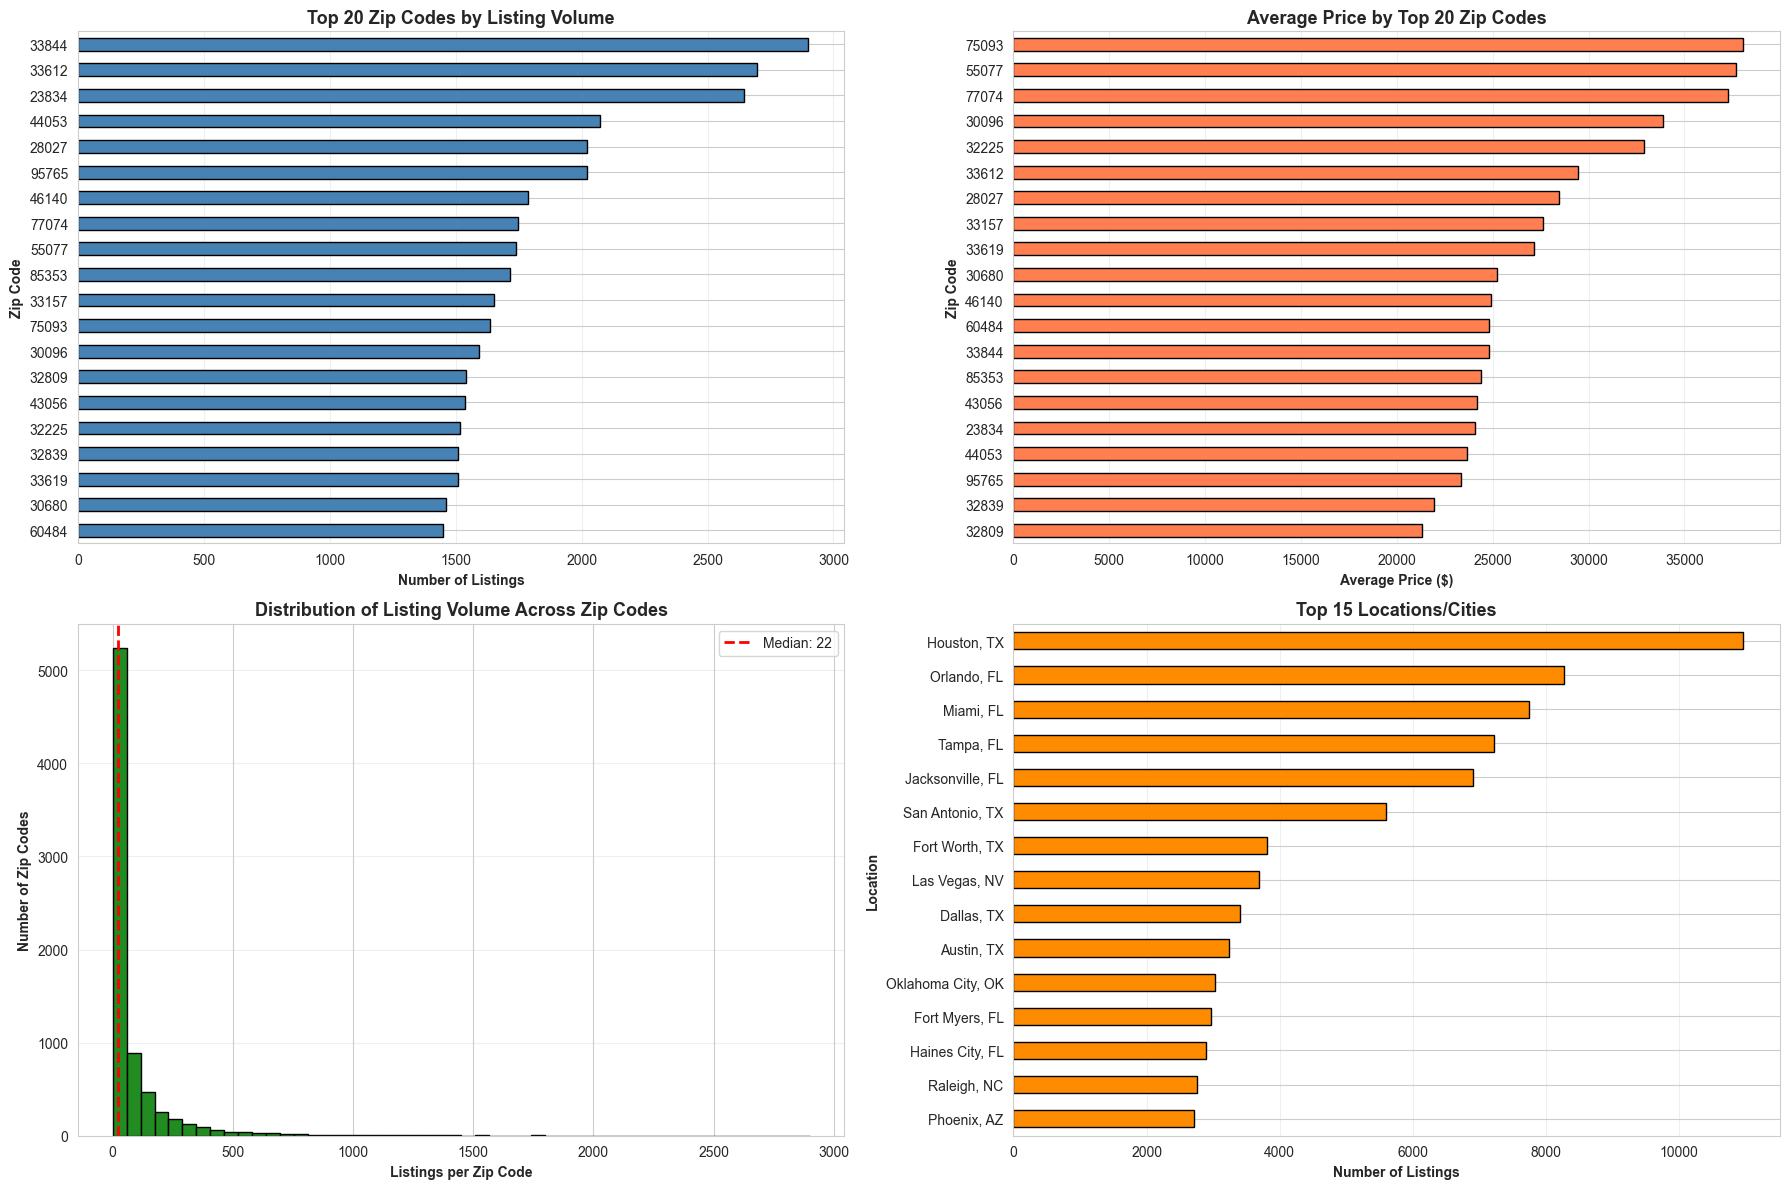

In [202]:
print("\n" + "="*80)
print("GEOGRAPHIC DISTRIBUTION OF LISTINGS")
print("="*80)

# Clean and prepare location data
listings_geo = listings[listings['locationCode'].notna()].copy()
listings_geo['zip_code'] = listings_geo['locationCode'].astype(str).str[:5]

# Filter out invalid zip codes (must be 5 digits)
listings_geo = listings_geo[listings_geo['zip_code'].str.match(r'^\d{5}$', na=False)]

print(f"\nTotal listings with valid zip codes: {len(listings_geo):,}")
print(f"Unique zip codes: {listings_geo['zip_code'].nunique():,}")

# Aggregate by zip code
zip_aggregation = listings_geo.groupby('zip_code').agg({
    'vin': 'count',
    'price': 'mean',
    'mileage': 'mean',
    'make': lambda x: x.value_counts().index[0] if len(x) > 0 and len(x.value_counts()) > 0 else 'N/A'
}).round(2)
zip_aggregation.columns = ['Listing Count', 'Avg Price', 'Avg Mileage', 'Top Make']
zip_aggregation = zip_aggregation.reset_index()
zip_aggregation = zip_aggregation.sort_values('Listing Count', ascending=False)

print(f"\nTop 15 Zip Codes by Listing Count:")
top_zips = zip_aggregation.head(15)
print(top_zips.to_string(index=False))

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Chart 1: Top 20 Zip Codes by Count
top_20_zips = zip_aggregation.head(20).sort_values('Listing Count', ascending=True)
top_20_zips.plot(x='zip_code', y='Listing Count', kind='barh', ax=axes[0, 0],
                color='steelblue', edgecolor='black', legend=False)
axes[0, 0].set_xlabel('Number of Listings', fontweight='bold')
axes[0, 0].set_ylabel('Zip Code', fontweight='bold')
axes[0, 0].set_title('Top 20 Zip Codes by Listing Volume', fontweight='bold', fontsize=13)
axes[0, 0].grid(axis='x', alpha=0.3)

# Chart 2: Price Distribution Across Top Zip Codes
top_20_price = zip_aggregation.head(20).sort_values('Avg Price', ascending=True)
top_20_price.plot(x='zip_code', y='Avg Price', kind='barh', ax=axes[0, 1],
                 color='coral', edgecolor='black', legend=False)
axes[0, 1].set_xlabel('Average Price ($)', fontweight='bold')
axes[0, 1].set_ylabel('Zip Code', fontweight='bold')
axes[0, 1].set_title('Average Price by Top 20 Zip Codes', fontweight='bold', fontsize=13)
axes[0, 1].grid(axis='x', alpha=0.3)

# Chart 3: Zip Code Concentration (Histogram)
zip_aggregation['Listing Count'].hist(bins=50, ax=axes[1, 0], color='forestgreen', edgecolor='black')
axes[1, 0].set_xlabel('Listings per Zip Code', fontweight='bold')
axes[1, 0].set_ylabel('Number of Zip Codes', fontweight='bold')
axes[1, 0].set_title('Distribution of Listing Volume Across Zip Codes', fontweight='bold', fontsize=13)
axes[1, 0].grid(axis='y', alpha=0.3)
axes[1, 0].axvline(zip_aggregation['Listing Count'].median(), color='red', linestyle='--',
                   linewidth=2, label=f"Median: {zip_aggregation['Listing Count'].median():.0f}")
axes[1, 0].legend()

# Chart 4: Location Distribution (if location field exists)
if 'location' in listings.columns and listings['location'].notna().sum() > 0:
    location_counts = listings[listings['location'].notna()]['location'].value_counts().head(15)
    location_counts.sort_values(ascending=True).plot(kind='barh', ax=axes[1, 1],
                                                     color='darkorange', edgecolor='black')
    axes[1, 1].set_xlabel('Number of Listings', fontweight='bold')
    axes[1, 1].set_ylabel('Location', fontweight='bold')
    axes[1, 1].set_title('Top 15 Locations/Cities', fontweight='bold', fontsize=13)
    axes[1, 1].grid(axis='x', alpha=0.3)
else:
    axes[1, 1].text(0.5, 0.5, 'Location data not available',
                   ha='center', va='center', transform=axes[1, 1].transAxes, fontsize=12)
    axes[1, 1].set_title('Location Distribution - No Data', fontweight='bold')

plt.tight_layout()
plt.show()


In [ ]:
# ## 20. Summary Insights


In [196]:
print("\n" + "="*80)
print("KEY INSIGHTS SUMMARY")
print("="*80)
print(f"\n1. DATASET SCOPE:")
print(f"   - Total Listings: {len(listings):,}")
print(f"   - Unique Vehicles (VINs): {listings['vin'].nunique():,}")
print(f"   - Unique Makes: {listings['make'].nunique()}")
print(f"   - Unique Models: {listings['model'].nunique()}")
print(f"   - Year Range: {listings['year'].min()} - {listings['year'].max()}")

print(f"\n2. PRICING INSIGHTS:")
print(f"   - Average Price: ${listings['price'].mean():,.0f}")
print(f"   - Median Price: ${listings['price'].median():,.0f}")
print(f"   - Price Std Dev: ${listings['price'].std():,.0f}")
print(f"   - Price Range: ${listings['price'].min():,.0f} to ${listings['price'].max():,.0f}")

print(f"\n3. MILEAGE INSIGHTS:")
print(f"   - Average Mileage: {listings['mileage'].mean():,.0f} miles")
print(f"   - Median Mileage: {listings['mileage'].median():,.0f} miles")
print(f"   - Mileage Std Dev: {listings['mileage'].std():,.0f}")
print(f"   - Vehicles with 0 miles: {(listings['mileage'] == 0).sum():,}")

print(f"\n4. GEOGRAPHIC INSIGHTS:")
print(f"   - Total Unique Locations: {listings['location'].nunique()}")
location_counts = listings['location'].value_counts()
if len(location_counts) > 0:
    print(f"   - Top Location: {location_counts.index[0]} ({location_counts.iloc[0]:,} listings)")
else:
    print(f"   - Top Location: No location data available")

print(f"\n5. MAKE INSIGHTS:")
make_counts = listings['make'].value_counts()
if len(make_counts) > 0:
    print(f"   - Top Make: {make_counts.index[0]} ({make_counts.iloc[0]:,} listings)")
else:
    print(f"   - Top Make: No make data available")

if 'price_by_make' in locals() and len(price_by_make) > 0 and 'Mean' in price_by_make.columns:
    print(f"   - Most Expensive Make (Avg): ${float(price_by_make['Mean'].max()):,.0f}")
    print(f"   - Least Expensive Make (Avg): ${float(price_by_make['Mean'].min()):,.0f}")
else:
    print(f"   - Make pricing data: Not available")

print("\n" + "="*80)



KEY INSIGHTS SUMMARY

1. DATASET SCOPE:
   - Total Listings: 651,857
   - Unique Vehicles (VINs): 651,780
   - Unique Makes: 61
   - Unique Models: 24091
   - Year Range: 0 - 2027

2. PRICING INSIGHTS:
   - Average Price: $31,099
   - Median Price: $24,995
   - Price Std Dev: $29,683
   - Price Range: $90 to $4,590,000

3. MILEAGE INSIGHTS:
   - Average Mileage: 55,197 miles
   - Median Mileage: 45,095 miles
   - Mileage Std Dev: 269,599
   - Vehicles with 0 miles: 0

4. GEOGRAPHIC INSIGHTS:
   - Total Unique Locations: 7363
   - Top Location: Houston, TX (10,964 listings)

5. MAKE INSIGHTS:
   - Top Make: Nissan (35,397 listings)
   - Most Expensive Make (Avg): $37,558
   - Least Expensive Make (Avg): $20,086

